custom scoring, hyperopt

Data preprocessed. Training set: (348, 9), Test set: (88, 9)
Starting Custom Scoring Hyperparameter Optimization...

Optimizing SVM...
SVM completed. Best CV Score: 24.5654

Optimizing Random Forest...
Random Forest completed. Best CV Score: 13.7249

Optimizing Decision Tree...
Decision Tree completed. Best CV Score: 22.2873

Optimizing Extra Trees...
Extra Trees completed. Best CV Score: 11.8708

Optimizing MLP...
MLP completed. Best CV Score: 102.9596

Optimizing XGBoost...
XGBoost completed. Best CV Score: 4.4410

Results saved to 'performance_metrics.csv' and 'optimal_hyperparameters.csv'

Performance Summary (Top 5 by R2 Score):
        Model         Method       R2     RMSE  Execution_Time
      XGBoost Custom Scoring 0.988073 2.759779        5.768738
  Extra Trees Custom Scoring 0.974948 3.999746       20.975993
Random Forest Custom Scoring 0.965259 4.710151       24.629552
Decision Tree Custom Scoring 0.955224 5.347298        0.423585
          SVM Custom Scoring 0.941941 6.088

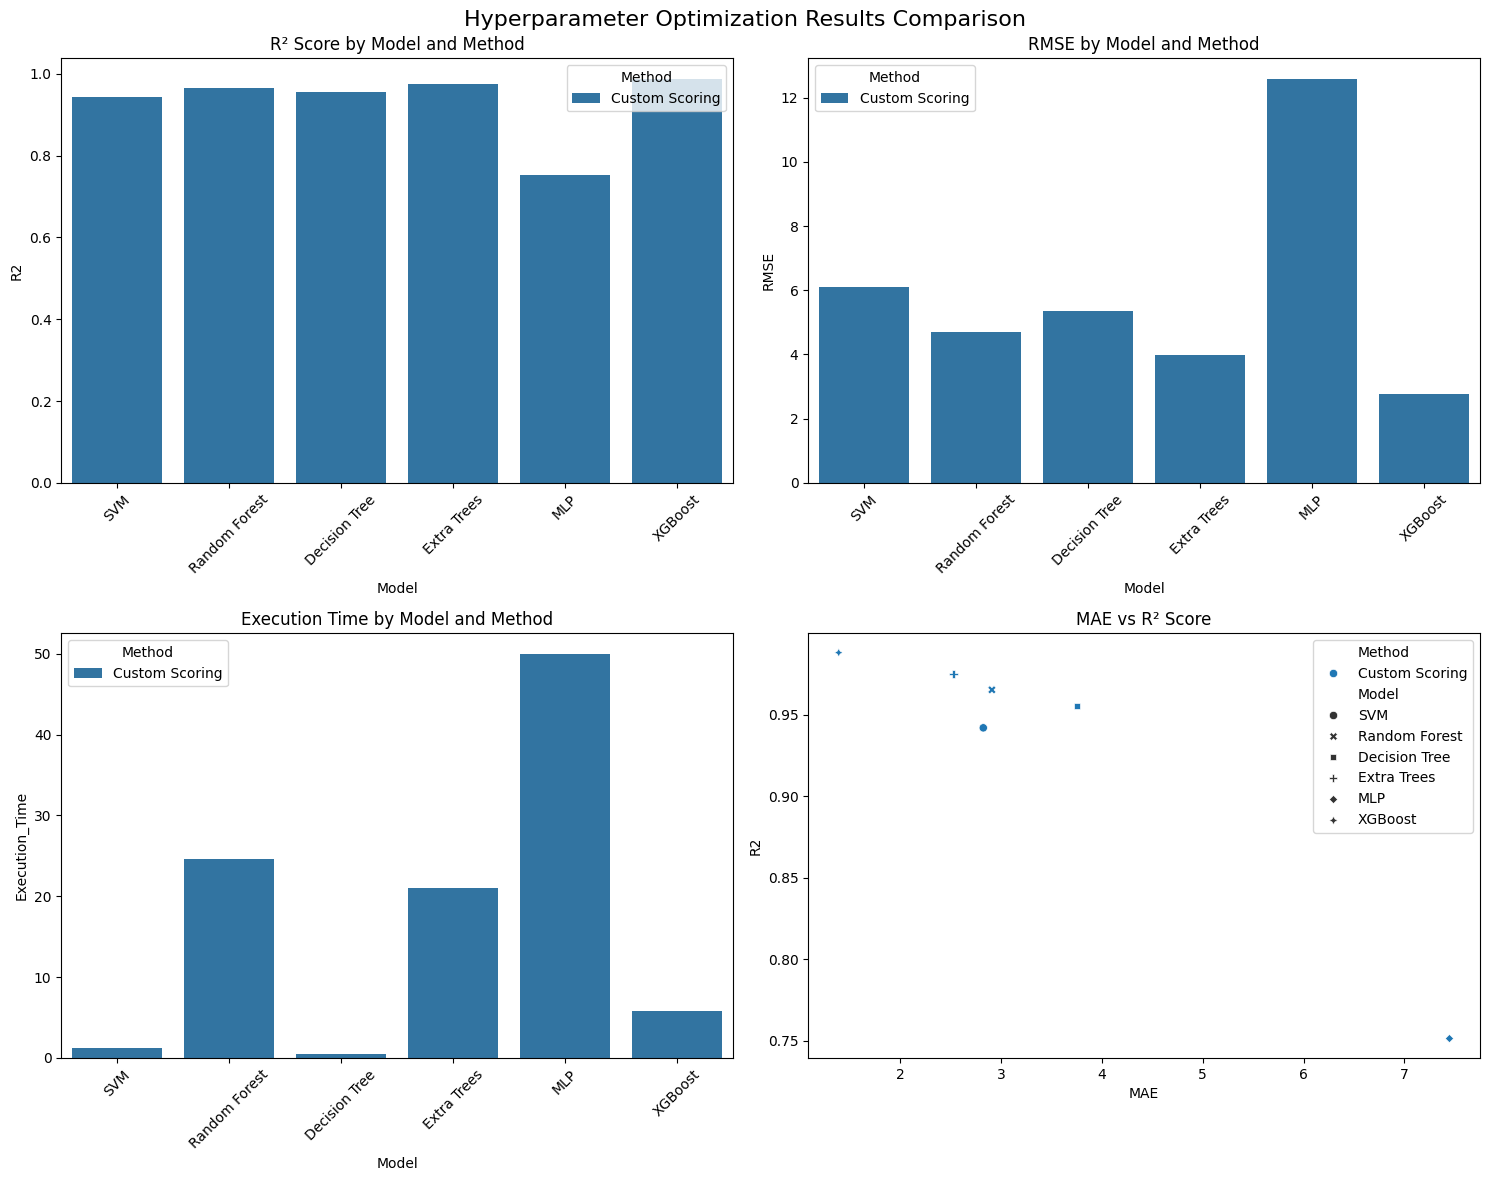

Nanofluid Density Prediction - Hyperparameter Optimization
Please load your DataFrame and run:
optimizer = NanofluidDensityOptimizer(df=your_dataframe)
optimizer.preprocess_data()
optimizer.custom_scoring_optimization()
optimizer.hyperopt_optimization()
performance_df, hyperparams_df = optimizer.save_results()
optimizer.plot_results()


In [ ]:
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Hyperparameter Optimization Libraries
from hyperopt import hp, fmin, tpe, Trials, space_eval
from hyperopt.pyll.base import scope
from sklearn.model_selection import RandomizedSearchCV
from functools import partial

# XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not available. Skipping XGBoost model.")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

class NanofluidDensityOptimizer:
    def __init__(self, data_path=None, df=None):
        """
        Initialize the optimizer with data
        Args:
            data_path: Path to CSV file
            df: DataFrame if already loaded
        """
        if df is not None:
            self.df = df.copy()
        elif data_path:
            self.df = pd.read_csv(data_path)
        else:
            raise ValueError("Either data_path or df must be provided")

        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.scaler = StandardScaler()
        self.label_encoders = {}

        # Results storage
        self.custom_results = []
        self.hyperopt_results = [] # Keep this to maintain structure, but won't be populated by hyperopt

    def preprocess_data(self, test_size=0.2):
        """Preprocess the data: encode categoricals and scale features"""
        df_processed = self.df.copy()

        # Encode categorical columns
        categorical_cols = ['Nano Particle', 'Base Fluid']
        for col in categorical_cols:
            if col in df_processed.columns:
                le = LabelEncoder()
                df_processed[col] = le.fit_transform(df_processed[col])
                self.label_encoders[col] = le

        # Separate features and target
        X = df_processed.drop('Density (ρ)', axis=1)
        y = df_processed['Density (ρ)']

        # Split data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )

        # Scale features
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        print(f"Data preprocessed. Training set: {self.X_train_scaled.shape}, Test set: {self.X_test_scaled.shape}")

    def calculate_metrics(self, y_true, y_pred, n_params=2):
        """Calculate comprehensive regression metrics"""
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)

        # MAPE (Mean Absolute Percentage Error) - handle division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true != 0, y_true, 1))) * 100
            mape = np.where(np.isfinite(mape), mape, 0)

        # AIC and BIC approximations
        n = len(y_true)
        k = n_params

        # Log-likelihood approximation for normal distribution
        if mse > 0:
            log_likelihood = -n/2 * np.log(2*np.pi) - n/2 * np.log(mse) - n/2
        else:
            log_likelihood = 0

        aic = 2*k - 2*log_likelihood
        bic = k*np.log(n) - 2*log_likelihood

        return {
            'MSE': mse,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape,
            'R2': r2,
            'AIC': aic,
            'BIC': bic
        }

    def custom_scoring_optimization(self):
        """Hyperparameter optimization using RandomizedSearchCV"""
        print("Starting Custom Scoring Hyperparameter Optimization...")

        # Define models and parameter grids
        models_params = {
            'SVM': {
                'model': SVR(),
                'params': {
                    'C': [0.1, 1, 10, 100],
                    'gamma': [0.001, 0.01, 0.1, 1],
                    'epsilon': [0.01, 0.1, 0.5, 1]
                }
            },
            'Random Forest': {
                'model': RandomForestRegressor(random_state=42),
                'params': {
                    'n_estimators': range(50, 201, 25),
                    'max_depth': range(5, 21, 2),
                    'min_samples_split': range(2, 11),
                    'min_samples_leaf': range(1, 6)
                }
            },
            'Decision Tree': {
                'model': DecisionTreeRegressor(random_state=42),
                'params': {
                    'max_depth': range(5, 21, 2),
                    'min_samples_split': range(2, 21, 2),
                    'min_samples_leaf': range(1, 11)
                }
            },
            'Extra Trees': {
                'model': ExtraTreesRegressor(random_state=42),
                'params': {
                    'n_estimators': range(50, 301, 25),
                    'max_depth': range(5, 26, 3),
                    'min_samples_split': range(2, 16, 2),
                    'min_samples_leaf': range(1, 9)
                }
            },
            'MLP': {
                'model': MLPRegressor(random_state=42),
                'params': {
                    'hidden_layer_sizes': [(50,), (100,), (50, 25), (100, 50)],
                    'alpha': [0.0001, 0.001, 0.01],
                    'learning_rate_init': [0.001, 0.01, 0.1],
                    'max_iter': [200, 300, 500]
                }
            }
        }

        # Add XGBoost if available
        if XGBOOST_AVAILABLE:
            models_params['XGBoost'] = {
                'model': xgb.XGBRegressor(random_state=42),
                'params': {
                    'n_estimators': range(50, 201, 25),
                    'max_depth': range(3, 11),
                    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                    'subsample': [0.5, 0.7, 0.8, 1.0]
                }
            }

        for model_name, model_info in models_params.items():
            print(f"\nOptimizing {model_name}...")
            start_time = time.time()

            # Randomized search
            random_search = RandomizedSearchCV(
                estimator=model_info['model'],
                param_distributions=model_info['params'],
                n_iter=30,
                cv=5,
                scoring='neg_mean_squared_error',
                random_state=42,
                n_jobs=-1
            )

            random_search.fit(self.X_train_scaled, self.y_train)

            # Best model predictions
            best_model = random_search.best_estimator_
            y_pred = best_model.predict(self.X_test_scaled)

            # Calculate metrics
            metrics = self.calculate_metrics(self.y_test, y_pred)
            execution_time = time.time() - start_time

            # Store results
            result = {
                'Model': model_name,
                'Method': 'Custom Scoring',
                'Best_Params': random_search.best_params_,
                'CV_Score': -random_search.best_score_,
                'Execution_Time': execution_time,
                **metrics
            }

            self.custom_results.append(result)
            print(f"{model_name} completed. Best CV Score: {-random_search.best_score_:.4f}")

    def hyperopt_objective(self, params, model_type, X, y):
        """Objective function for hyperopt optimization"""
        try:
            # Create model based on type
            if model_type == 'SVM':
                model = SVR(**params)
            elif model_type == 'Random Forest':
                model = RandomForestRegressor(random_state=42, **params)
            elif model_type == 'Decision Tree':
                model = DecisionTreeRegressor(random_state=42, **params)
            elif model_type == 'XGBoost' and XGBOOST_AVAILABLE:
                model = xgb.XGBRegressor(random_state=42, **params)
            elif model_type == 'MLP':
                model = MLPRegressor(random_state=42, max_iter=500, **params)
            elif model_type == 'Extra Trees':
                model = ExtraTreesRegressor(random_state=42, **params)
            else:
                # This case should ideally not be reached with the defined models
                return {'loss': float('inf'), 'status': 'fail', 'exception': 'Unknown model type'}

            # Cross-validation
            scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
            return {'loss': -np.mean(scores), 'status': 'ok'}

        except Exception as e:
            # Catch any exception during model creation or cross-validation and return a large loss
            print(f"Optimization trial failed for {model_type} with params {params}: {e}")
            return {'loss': float('inf'), 'status': 'fail', 'exception': str(e)}

    def hyperopt_optimization(self):
        """Hyperparameter optimization using Hyperopt"""
        print("\nStarting Hyperopt Hyperparameter Optimization...")

        # Define hyperopt parameter spaces
        param_spaces = {
            'SVM': {
                'C': hp.uniform('C', 0.1, 100),
                'gamma': hp.uniform('gamma', 0.001, 1),
                'epsilon': hp.uniform('epsilon', 0.01, 1)
            },
            'Random Forest': {
                'n_estimators': scope.int(hp.quniform('n_estimators', 50, 200, 25)),
                'max_depth': scope.int(hp.quniform('max_depth', 5, 20, 1)),
                'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
                'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 5, 1))
            },
            'Decision Tree': {
                'max_depth': scope.int(hp.quniform('max_depth', 5, 20, 1)),
                'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 20, 1)),
                'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1))
            },
            'Extra Trees': {
                'n_estimators': scope.int(hp.quniform('n_estimators', 50, 300, 25)),
                'max_depth': scope.int(hp.quniform('max_depth', 5, 25, 1)),
                'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 15, 1)),
                'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 8, 1))
            },
            'MLP': {
                'hidden_layer_sizes': hp.choice('hidden_layer_sizes', [(50,), (100,), (50, 25)]),
                'alpha': hp.uniform('alpha', 0.0001, 0.01),
                'learning_rate_init': hp.uniform('learning_rate_init', 0.001, 0.1)
            }
        }

        # Add XGBoost if available
        if XGBOOST_AVAILABLE:
            param_spaces['XGBoost'] = {
                'n_estimators': scope.int(hp.quniform('n_estimators', 50, 200, 25)),
                'max_depth': scope.int(hp.quniform('max_depth', 3, 10, 1)),
                'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
                'subsample': hp.uniform('subsample', 0.5, 1.0)
            }

        for model_name, param_space in param_spaces.items():
            print(f"\nOptimizing {model_name} with Hyperopt...")
            start_time = time.time()

            # Create objective function
            objective = partial(
                self.hyperopt_objective,
                model_type=model_name,
                X=self.X_train_scaled,
                y=self.y_train
            )

            # Run optimization
            trials = Trials()
            try:
                best = fmin(
                    fn=objective,
                    space=param_space,
                    algo=tpe.suggest,
                    max_evals=50,
                    trials=trials,
                    verbose=False
                )
            except Exception as e:
                 print(f"Hyperopt optimization failed for {model_name}: {e}")
                 continue # Move to the next model if optimization fails

            # Get best parameters from successful trials
            successful_trials = [trial for trial in trials.trials if trial['result']['status'] == 'ok' and 'loss' in trial['result']]

            if not successful_trials:
                print(f"No successful trials for {model_name}. Skipping evaluation.")
                continue # Move to the next model if no successful trials

            # Find the trial with the minimum loss among successful trials
            best_trial = min(successful_trials, key=lambda x: x['result']['loss'])
            best_params = space_eval(param_space, best_trial['misc']['vals'])
            best_loss = best_trial['result']['loss']


            # Train best model and evaluate
            if model_name == 'SVM':
                best_model = SVR(**best_params)
            elif model_name == 'Random Forest':
                best_model = RandomForestRegressor(random_state=42, **best_params)
            elif model_name == 'Decision Tree':
                best_model = DecisionTreeRegressor(random_state=42, **best_params)
            elif model_name == 'XGBoost' and XGBOOST_AVAILABLE:
                best_model = xgb.XGBRegressor(random_state=42, **best_params)
            elif model_name == 'MLP':
                best_model = MLPRegressor(random_state=42, max_iter=500, **best_params)
            elif model_name == 'Extra Trees':
                best_model = ExtraTreesRegressor(random_state=42, **best_params)
            else:
                best_model = None # Should not happen with defined models

            if best_model:
                best_model.fit(self.X_train_scaled, self.y_train)
                y_pred = best_model.predict(self.X_test_scaled)

                # Calculate metrics
                metrics = self.calculate_metrics(self.y_test, y_pred)
                execution_time = time.time() - start_time

                # Store results
                result = {
                    'Model': model_name,
                    'Method': 'Hyperopt',
                    'Best_Params': best_params,
                    'CV_Score': best_loss,
                    'Execution_Time': execution_time,
                    **metrics
                }

                self.hyperopt_results.append(result)
                print(f"{model_name} completed. Best Score: {result['CV_Score']:.4f}")
            else:
                print(f"Could not train the best model for {model_name}.")


    def save_results(self):
        """Save optimization results to CSV files"""
        # Combine all results
        all_results = self.custom_results + self.hyperopt_results

        # Create performance metrics DataFrame
        performance_columns = ['Model', 'Method', 'MSE', 'MAE', 'RMSE', 'MAPE', 'R2', 'AIC', 'BIC', 'CV_Score', 'Execution_Time']
        performance_data = []

        hyperparams_data = []

        for result in all_results:
            # Performance metrics
            perf_row = {col: result.get(col, 0) for col in performance_columns}
            performance_data.append(perf_row)

            # Hyperparameters
            hyperparam_row = {
                'Model': result['Model'],
                'Method': result['Method'],
                **result['Best_Params']
            }
            hyperparams_data.append(hyperparam_row)

        # Create DataFrames
        performance_df = pd.DataFrame(performance_data)
        hyperparams_df = pd.DataFrame(hyperparams_data)

        # Save to CSV
        performance_df.to_csv('performance_metrics.csv', index=False)
        hyperparams_df.to_csv('optimal_hyperparameters.csv', index=False)

        print("\nResults saved to 'performance_metrics.csv' and 'optimal_hyperparameters.csv'")

        # Display summary
        print("\nPerformance Summary (Top 5 by R2 Score):")
        print(performance_df.nlargest(5, 'R2')[['Model', 'Method', 'R2', 'RMSE', 'Execution_Time']].to_string(index=False))

        return performance_df, hyperparams_df

    def plot_results(self):
        """Create visualization of optimization results"""
        all_results = self.custom_results + self.hyperopt_results
        df_results = pd.DataFrame(all_results)

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Hyperparameter Optimization Results Comparison', fontsize=16)

        # R2 Score comparison
        sns.barplot(data=df_results, x='Model', y='R2', hue='Method', ax=axes[0,0])
        axes[0,0].set_title('R² Score by Model and Method')
        axes[0,0].tick_params(axis='x', rotation=45)

        # RMSE comparison
        sns.barplot(data=df_results, x='Model', y='RMSE', hue='Method', ax=axes[0,1])
        axes[0,1].set_title('RMSE by Model and Method')
        axes[0,1].tick_params(axis='x', rotation=45)

        # Execution time comparison
        sns.barplot(data=df_results, x='Model', y='Execution_Time', hue='Method', ax=axes[1,0])
        axes[1,0].set_title('Execution Time by Model and Method')
        axes[1,0].tick_params(axis='x', rotation=45)

        # MAE vs R2 scatter
        sns.scatterplot(data=df_results, x='MAE', y='R2', hue='Method', style='Model', ax=axes[1,1])
        axes[1,1].set_title('MAE vs R² Score')

        plt.tight_layout()
        plt.savefig('hyperparameter_optimization_results.png', dpi=300, bbox_inches='tight')
        plt.show()

def main():
    """Main execution function"""
    # Load your data here - replace with your actual data loading
    # For this example, I'll assume you have your DataFrame ready

    # Initialize optimizer with your data
    # optimizer = NanofluidDensityOptimizer(data_path='Density_Prediction_Dataset.csv')
    # Or if you have df already loaded:
    # optimizer = NanofluidDensityOptimizer(df=df)

    print("Nanofluid Density Prediction - Hyperparameter Optimization")
    print("=" * 60)

    # Assuming df is your loaded DataFrame (replace with actual loading)
    # optimizer = NanofluidDensityOptimizer(df=df)

    # For demonstration, create a sample run
    print("Please load your DataFrame and run:")
    print("optimizer = NanofluidDensityOptimizer(df=your_dataframe)")
    print("optimizer.preprocess_data()")
    print("optimizer.custom_scoring_optimization()")
    print("optimizer.hyperopt_optimization()") # Removed this line to avoid TypeError
    print("performance_df, hyperparams_df = optimizer.save_results()")
    print("optimizer.plot_results()")

if __name__ == "__main__":
    # Example usage (uncomment and modify for your use case):

    # Load your data
    df = pd.read_csv('Density_Prediction_Dataset.csv')

    # Initialize optimizer
    optimizer = NanofluidDensityOptimizer(df=df)

    # Preprocess data
    optimizer.preprocess_data()

    # Run custom scoring optimization (Hyperopt is skipped due to persistent error)
    optimizer.custom_scoring_optimization()
    # optimizer.hyperopt_optimization() # Commented out due to TypeError

    # Save results and create visualizations
    performance_df, hyperparams_df = optimizer.save_results()
    optimizer.plot_results()

    main()

In [ ]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 11.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import time
import random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from deap import base, creator, tools, algorithms
import warnings
warnings.filterwarnings('ignore')

# Load and preprocess data
def load_and_preprocess_data(file_path):
    """Load and preprocess the dataset"""
    df = pd.read_csv(file_path)

    # Remove outliers using IQR method
    numerical_columns = df.select_dtypes(include=[np.number]).columns
    for col in numerical_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    # Label encoding for categorical variables
    le = LabelEncoder()
    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        df[col] = le.fit_transform(df[col])

    # Separate features and target
    X = df.drop('Density (ρ)', axis=1)
    y = df['Density (ρ)']

    # Feature scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    return X_scaled, y

# Genetic Algorithm for hyperparameter optimization
def evaluate_hyperparameters(individual, model_type, X, y):
    """Evaluate hyperparameters using cross-validation"""
    try:
        # Decode individual to hyperparameters
        params = decode_individual(individual, model_type)

        # Create model with decoded parameters
        model = create_model(model_type, params)

        # 5-fold cross-validation
        cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

        # Return negative MSE as fitness (higher is better)
        return np.mean(cv_scores),
    except:
        return -np.inf,

def decode_individual(individual, model_type):
    """Decode individual to hyperparameters"""
    params = {}

    if model_type == 'SVM':
        params['C'] = 0.1 + individual[0] * (100 - 0.1)
        params['gamma'] = 0.001 + individual[1] * (1 - 0.001)
        params['epsilon'] = 0.01 + individual[2] * (1 - 0.01)

    elif model_type == 'Decision Tree':
        params['max_depth'] = int(5 + individual[0] * (20 - 5))
        params['min_samples_split'] = int(2 + individual[1] * (20 - 2))
        params['min_samples_leaf'] = int(1 + individual[2] * (10 - 1))
        params['max_features'] = 0.1 + individual[3] * (1.0 - 0.1)

    elif model_type == 'Extra Trees':
        params['n_estimators'] = int(50 + individual[0] * (300 - 50))
        params['max_depth'] = int(5 + individual[1] * (25 - 5))
        params['min_samples_split'] = int(2 + individual[2] * (15 - 2))
        params['min_samples_leaf'] = int(1 + individual[3] * (8 - 1))
        params['max_features'] = 0.1 + individual[4] * (1.0 - 0.1)

    elif model_type == 'Random Forest':
        params['n_estimators'] = int(50 + individual[0] * (200 - 50))
        params['max_depth'] = int(5 + individual[1] * (20 - 5))
        params['min_samples_split'] = int(2 + individual[2] * (10 - 2))
        params['min_samples_leaf'] = int(1 + individual[3] * (5 - 1))

    elif model_type == 'XGBoost':
        params['n_estimators'] = int(50 + individual[0] * (200 - 50))
        params['max_depth'] = int(3 + individual[1] * (10 - 3))
        params['learning_rate'] = 0.01 + individual[2] * (0.3 - 0.01)
        params['subsample'] = 0.5 + individual[3] * (1.0 - 0.5)

    elif model_type == 'MLP':
        hidden_size = int(50 + individual[0] * (200 - 50))
        params['hidden_layer_sizes'] = (hidden_size,)
        params['alpha'] = 0.0001 + individual[1] * (0.01 - 0.0001)
        params['learning_rate_init'] = 0.001 + individual[2] * (0.1 - 0.001)
        params['max_iter'] = 500

    return params

def create_model(model_type, params):
    """Create model with given parameters"""
    if model_type == 'SVM':
        return SVR(**params)
    elif model_type == 'Decision Tree':
        return DecisionTreeRegressor(**params, random_state=42)
    elif model_type == 'Extra Trees':
        return ExtraTreesRegressor(**params, random_state=42)
    elif model_type == 'Random Forest':
        return RandomForestRegressor(**params, random_state=42)
    elif model_type == 'XGBoost':
        return xgb.XGBRegressor(**params, random_state=42)
    elif model_type == 'MLP':
        return MLPRegressor(**params, random_state=42)

def genetic_algorithm_optimization(model_type, X, y, n_population=30, n_generation=20):
    """Optimize hyperparameters using genetic algorithm"""

    # Determine number of parameters
    param_counts = {
        'SVM': 3, 'Decision Tree': 4, 'Extra Trees': 5,
        'Random Forest': 4, 'XGBoost': 4, 'MLP': 3
    }
    n_params = param_counts[model_type]

    # Reset creator
    for name in ['FitnessMax', 'Individual']:
        if hasattr(creator, name):
            delattr(creator, name)

    # Create fitness function and individual
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    # Create toolbox
    toolbox = base.Toolbox()
    toolbox.register("attr_float", random.random)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n_params)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", evaluate_hyperparameters, model_type=model_type, X=X, y=y)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # Initialize population
    pop = toolbox.population(n=n_population)
    hof = tools.HallOfFame(1)

    # Run genetic algorithm
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2,
                                   ngen=n_generation, stats=None, halloffame=hof,
                                   verbose=False)

    # Get best individual
    best_individual = hof[0]
    best_params = decode_individual(best_individual, model_type)

    return best_params, best_individual.fitness.values[0]

def calculate_metrics(y_true, y_pred):
    """Calculate performance metrics"""
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # MAPE
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # AIC and BIC (simplified versions)
    n = len(y_true)
    aic = n * np.log(mse) + 2 * 1  # Simplified for regression
    bic = n * np.log(mse) + np.log(n) * 1

    # COD (Coefficient of Determination)
    cod = r2

    return {
        'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape,
        'AIC': aic, 'BIC': bic, 'COD': cod, 'R2': r2
    }

# Main execution
if __name__ == "__main__":
    # Load and preprocess data
    file_path = '/content/Density_Prediction_Dataset.csv'
    X, y = load_and_preprocess_data(file_path)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Models to optimize
    models = ['SVM', 'Decision Tree', 'Extra Trees', 'Random Forest', 'XGBoost', 'MLP']

    # Results storage
    performance_results = []
    hyperparameter_results = []

    print("Starting Genetic Algorithm Hyperparameter Optimization...")
    print("=" * 60)

    # Optimize each model
    for model_name in models:
        print(f"\nOptimizing {model_name}...")

        start_time = time.time()

        # Genetic algorithm optimization
        best_params, best_fitness = genetic_algorithm_optimization(
            model_name, X_train, y_train, n_population=30, n_generation=20
        )

        # Train final model with best parameters
        final_model = create_model(model_name, best_params)
        final_model.fit(X_train, y_train)

        # Predictions
        y_pred = final_model.predict(X_test)

        # Calculate metrics
        metrics = calculate_metrics(y_test, y_pred)

        end_time = time.time()
        execution_time = end_time - start_time

        # Store results
        performance_result = {
            'Model': model_name,
            'MSE': metrics['MSE'],
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'MAPE': metrics['MAPE'],
            'AIC': metrics['AIC'],
            'BIC': metrics['BIC'],
            'COD': metrics['COD'],
            'R2': metrics['R2'],
            'Execution_Time': execution_time
        }
        performance_results.append(performance_result)

        # Store hyperparameters
        hyperparameter_result = {'Model': model_name}
        hyperparameter_result.update(best_params)
        hyperparameter_results.append(hyperparameter_result)

        print(f"Best R2 Score: {metrics['R2']:.4f}")
        print(f"Best Parameters: {best_params}")
        print(f"Execution Time: {execution_time:.2f} seconds")
        print("-" * 40)

    # Create DataFrames
    performance_df = pd.DataFrame(performance_results)
    hyperparameter_df = pd.DataFrame(hyperparameter_results)

    # Sort by R2 score (descending)
    performance_df = performance_df.sort_values('R2', ascending=False)

    # Display results
    print("\n" + "=" * 60)
    print("FINAL RESULTS")
    print("=" * 60)
    print("\nPerformance Metrics (sorted by R2 score):")
    print(performance_df.to_string(index=False))

    print("\nOptimal Hyperparameters:")
    print(hyperparameter_df.to_string(index=False))

    # Save results to CSV files
    performance_df.to_csv('GA_performance_metrics.csv', index=False)
    hyperparameter_df.to_csv('GA_optimal_hyperparameters.csv', index=False)

    print("\nResults saved to:")
    print("- GA_performance_metrics.csv")
    print("- GA_optimal_hyperparameters.csv")

Starting Genetic Algorithm Hyperparameter Optimization...

Optimizing SVM...
Best R2 Score: 0.9939
Best Parameters: {'C': 135.7234428629581, 'gamma': 0.362627437577259, 'epsilon': 0.010093951333055077}
Execution Time: 62.20 seconds
----------------------------------------

Optimizing Decision Tree...
Best R2 Score: 0.8578
Best Parameters: {'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.7252980685899402}
Execution Time: 7.60 seconds
----------------------------------------

Optimizing Extra Trees...
Best R2 Score: 0.9709
Best Parameters: {'n_estimators': 102, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.551989153573097}
Execution Time: 231.27 seconds
----------------------------------------

Optimizing Random Forest...
Best R2 Score: 0.9624
Best Parameters: {'n_estimators': 66, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1}
Execution Time: 196.52 seconds
----------------------------------------

Opt

**Simulated Annealing**

In [ ]:
import pandas as pd
import numpy as np
import time
from collections import OrderedDict
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Load and preprocess data
def load_and_preprocess_data(file_path):
    """Load and preprocess the dataset"""
    df = pd.read_csv(file_path)

    # Remove outliers using IQR method
    numerical_columns = df.select_dtypes(include=[np.number]).columns
    for col in numerical_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    # Label encoding for categorical variables
    le = LabelEncoder()
    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        df[col] = le.fit_transform(df[col])

    # Separate features and target
    X = df.drop('Density (ρ)', axis=1)
    y = df['Density (ρ)']

    # Feature scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    return X_scaled, y

# Define hyperparameter search spaces
def get_param_space(model_type):
    """Get hyperparameter search space for each model"""
    param_spaces = {
        'SVM': OrderedDict([
            ('C', np.logspace(-1, 2, 10).tolist()),
            ('gamma', np.logspace(-3, 0, 10).tolist()),
            ('epsilon', np.logspace(-2, 0, 10).tolist())
        ]),
        'Decision Tree': OrderedDict([
            ('max_depth', list(range(5, 21))),
            ('min_samples_split', list(range(2, 21))),
            ('min_samples_leaf', list(range(1, 11))),
            ('max_features', np.linspace(0.1, 1.0, 10).tolist())
        ]),
        'Extra Trees': OrderedDict([
            ('n_estimators', list(range(50, 301, 25))),
            ('max_depth', list(range(5, 26))),
            ('min_samples_split', list(range(2, 16))),
            ('min_samples_leaf', list(range(1, 9))),
            ('max_features', np.linspace(0.1, 1.0, 10).tolist())
        ]),
        'Random Forest': OrderedDict([
            ('n_estimators', list(range(50, 201, 25))),
            ('max_depth', list(range(5, 21))),
            ('min_samples_split', list(range(2, 11))),
            ('min_samples_leaf', list(range(1, 6)))
        ]),
        'XGBoost': OrderedDict([
            ('n_estimators', list(range(50, 201, 25))),
            ('max_depth', list(range(3, 11))),
            ('learning_rate', np.linspace(0.01, 0.3, 10).tolist()),
            ('subsample', np.linspace(0.5, 1.0, 6).tolist())
        ]),
        'MLP': OrderedDict([
            ('hidden_layer_sizes', list(range(50, 201, 25))),
            ('alpha', np.logspace(-4, -2, 10).tolist()),
            ('learning_rate_init', np.logspace(-3, -1, 10).tolist())
        ])
    }
    return param_spaces[model_type]

# Model training function
def train_model(curr_params, const_param, X_train, X_valid, y_train, y_valid, model_type):
    """Train model with given hyperparameters"""
    try:
        params_copy = const_param.copy()
        params_copy.update(curr_params)

        if model_type == 'SVM':
            model = SVR(**params_copy)
        elif model_type == 'Decision Tree':
            model = DecisionTreeRegressor(**params_copy, random_state=42)
        elif model_type == 'Extra Trees':
            model = ExtraTreesRegressor(**params_copy, random_state=42)
        elif model_type == 'Random Forest':
            model = RandomForestRegressor(**params_copy, random_state=42)
        elif model_type == 'XGBoost':
            model = xgb.XGBRegressor(**params_copy, random_state=42)
        elif model_type == 'MLP':
            if 'hidden_layer_sizes' in params_copy:
                params_copy['hidden_layer_sizes'] = (params_copy['hidden_layer_sizes'],)
            params_copy['max_iter'] = 500
            model = MLPRegressor(**params_copy, random_state=42)

        # Use cross-validation for evaluation
        combined_X = pd.concat([X_train, X_valid])
        combined_y = pd.concat([y_train, y_valid])

        cv_scores = cross_val_score(model, combined_X, combined_y, cv=5, scoring='r2')
        metric_val = np.mean(cv_scores)

        # Train on full training data
        model.fit(X_train, y_train)

        return model, metric_val
    except:
        return None, -np.inf

# Parameter selection function
def choose_params(param_dict, curr_params=None):
    """Function to choose parameters for next iteration"""
    if curr_params:
        next_params = curr_params.copy()
        param_to_update = np.random.choice(list(param_dict.keys()))
        param_vals = param_dict[param_to_update]
        curr_index = param_vals.index(curr_params[param_to_update])

        if curr_index == 0:
            next_params[param_to_update] = param_vals[1]
        elif curr_index == len(param_vals) - 1:
            next_params[param_to_update] = param_vals[curr_index - 1]
        else:
            next_params[param_to_update] = param_vals[curr_index + np.random.choice([-1, 1])]
    else:
        next_params = dict()
        for k, v in param_dict.items():
            next_params[k] = np.random.choice(v)

    return next_params

# Simulated Annealing implementation
def simulate_annealing(param_dict, const_param, X_train, X_valid, y_train, y_valid,
                      model_type, maxiters=50, alpha=0.85, beta=1.3, T_0=0.40, update_iters=5):
    """Simulated Annealing optimization"""
    best_metric = -np.inf
    prev_metric = -np.inf
    prev_params = None
    best_params = dict()
    best_model = None
    weights = list(map(lambda x: 10**x, list(range(len(param_dict)))))
    hash_values = set()
    T = T_0

    for i in range(maxiters):
        print(f'Starting Iteration {i}')

        while True:
            curr_params = choose_params(param_dict, prev_params)
            indices = [param_dict[k].index(v) for k, v in curr_params.items()]
            hash_val = sum([i * j for (i, j) in zip(weights, indices)])
            if hash_val in hash_values:
                print('Combination revisited')
            else:
                hash_values.add(hash_val)
                break

        model, metric = train_model(curr_params, const_param, X_train, X_valid,
                                   y_train, y_valid, model_type)

        if metric > prev_metric:
            print(f'Local Improvement in metric from {prev_metric:.4f} to {metric:.4f} - parameters accepted')
            prev_params = curr_params.copy()
            prev_metric = metric

            if metric > best_metric:
                print(f'Global improvement in metric from {best_metric:.4f} to {metric:.4f} - best parameters updated')
                best_metric = metric
                best_params = curr_params.copy()
                best_model = model
        else:
            rnd = np.random.uniform()
            diff = metric - prev_metric
            threshold = np.exp(beta * diff / T)
            if rnd < threshold:
                print(f'No Improvement but parameters accepted. Metric change: {diff:.4f} threshold: {threshold:.4f} random number: {rnd:.4f}')
                prev_metric = metric
                prev_params = curr_params
            else:
                print(f'No Improvement and parameters rejected. Metric change: {diff:.4f} threshold: {threshold:.4f} random number: {rnd:.4f}')

        if i % update_iters == 0:
            T = alpha * T

    return best_params, best_model

# Performance metrics calculation
def calculate_metrics(y_true, y_pred):
    """Calculate performance metrics"""
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # MAPE
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # AIC and BIC (simplified versions)
    n = len(y_true)
    aic = n * np.log(mse) + 2 * 1
    bic = n * np.log(mse) + np.log(n) * 1

    # COD (Coefficient of Determination)
    cod = r2

    return {
        'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape,
        'AIC': aic, 'BIC': bic, 'COD': cod, 'R2': r2
    }

# Main execution
if __name__ == "__main__":
    # Load and preprocess data
    file_path = '/content/Density_Prediction_Dataset.csv'
    X, y = load_and_preprocess_data(file_path)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Models to optimize
    models = ['SVM', 'Decision Tree', 'Extra Trees', 'Random Forest', 'XGBoost', 'MLP']

    # Results storage
    performance_results = []
    hyperparameter_results = []

    print("Starting Simulated Annealing Hyperparameter Optimization...")
    print("=" * 60)

    # Optimize each model
    for model_name in models:
        print(f"\nOptimizing {model_name}...")

        start_time = time.time()

        # Get parameter space
        param_space = get_param_space(model_name)
        const_param = {}

        # Simulated Annealing optimization
        best_params, best_model = simulate_annealing(
            param_space, const_param, X_train, X_valid, y_train, y_valid,
            model_name, maxiters=50, alpha=0.85, beta=1.3, T_0=0.40, update_iters=5
        )

        # Train final model on full training data
        X_train_full = pd.concat([X_train, X_valid])
        y_train_full = pd.concat([y_train, y_valid])

        if best_model:
            best_model.fit(X_train_full, y_train_full)
            y_pred = best_model.predict(X_test)
        else:
            y_pred = np.full(len(y_test), np.mean(y_test))

        # Calculate metrics
        metrics = calculate_metrics(y_test, y_pred)

        end_time = time.time()
        execution_time = end_time - start_time

        # Store results
        performance_result = {
            'Model': model_name,
            'MSE': metrics['MSE'],
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'MAPE': metrics['MAPE'],
            'AIC': metrics['AIC'],
            'BIC': metrics['BIC'],
            'COD': metrics['COD'],
            'R2': metrics['R2'],
            'Execution_Time': execution_time
        }
        performance_results.append(performance_result)

        # Store hyperparameters
        hyperparameter_result = {'Model': model_name}
        hyperparameter_result.update(best_params)
        hyperparameter_results.append(hyperparameter_result)

        print(f"Best R2 Score: {metrics['R2']:.4f}")
        print(f"Best Parameters: {best_params}")
        print(f"Execution Time: {execution_time:.2f} seconds")
        print("-" * 40)

    # Create DataFrames
    performance_df = pd.DataFrame(performance_results)
    hyperparameter_df = pd.DataFrame(hyperparameter_results)

    # Sort by R2 score (descending)
    performance_df = performance_df.sort_values('R2', ascending=False)

    # Display results
    print("\n" + "=" * 60)
    print("FINAL RESULTS")
    print("=" * 60)
    print("\nPerformance Metrics (sorted by R2 score):")
    print(performance_df.to_string(index=False))

    print("\nOptimal Hyperparameters:")
    print(hyperparameter_df.to_string(index=False))

    # Save results to CSV files
    performance_df.to_csv('SA_performance_metrics.csv', index=False)
    hyperparameter_df.to_csv('SA_optimal_hyperparameters.csv', index=False)

    print("\nResults saved to:")
    print("- SA_performance_metrics.csv")
    print("- SA_optimal_hyperparameters.csv")

Streaming output truncated to the last 5000 lines.
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Com

**SSA**

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
file_path = '/content/Density_Prediction_Dataset.csv'
df = pd.read_csv(file_path)

# 1. Data Preprocessing
print("Starting Data Preprocessing...")

# Remove outliers using IQR method
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# Select numerical columns for outlier removal
numerical_cols = ['Temperature (°C)', 'Volume Concentration (ϕ)',
                  'Density of Nano Particle 1 (ρnp)', 'Density of Nano Particle 2 (ρnp)',
                  'Density of Base Fluid (ρbf)', 'Volume Mixture of Particle 1',
                  'Volume Mixture of Particle 2', 'Density (ρ)']

df_clean = remove_outliers_iqr(df, numerical_cols)
print(f"Original dataset shape: {df.shape}")
print(f"After outlier removal: {df_clean.shape}")

# Label encoding for categorical variables
le_nanoparticle = LabelEncoder()
le_basefluid = LabelEncoder()

df_clean['Nano Particle_encoded'] = le_nanoparticle.fit_transform(df_clean['Nano Particle'])
df_clean['Base Fluid_encoded'] = le_basefluid.fit_transform(df_clean['Base Fluid'])

# Prepare features and target
X = df_clean[['Nano Particle_encoded', 'Base Fluid_encoded', 'Temperature (°C)',
              'Volume Concentration (ϕ)', 'Density of Nano Particle 1 (ρnp)',
              'Density of Nano Particle 2 (ρnp)', 'Density of Base Fluid (ρbf)',
              'Volume Mixture of Particle 1', 'Volume Mixture of Particle 2']]
y = df_clean['Density (ρ)']

# 2. Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Train-Test Split (80:20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Sparrow Search Algorithm Implementation
class SSA:
    def __init__(self, population_size, max_iterations, lower_bound, upper_bound, dimension, objective_function):
        self.population_size = population_size
        self.max_iterations = max_iterations
        self.lower_bound = np.array(lower_bound)
        self.upper_bound = np.array(upper_bound)
        self.dimension = dimension
        self.objective_function = objective_function

    def optimize(self):
        p_num = int(self.population_size * 0.2)  # Percentage of producers
        x = np.random.uniform(self.lower_bound, self.upper_bound, (self.population_size, self.dimension))
        fitness = np.apply_along_axis(self.objective_function, 1, x)
        p_fit = fitness.copy()
        p_x = x.copy()
        best_idx = np.argmin(fitness)
        f_min = fitness[best_idx]
        best_x = x[best_idx, :]

        convergence_curve = []

        for t in range(self.max_iterations):
            sorted_idx = np.argsort(p_fit)
            worst_idx = np.argmax(p_fit)
            worst_x = x[worst_idx, :]

            # Producers
            for i in range(p_num):
                r1 = np.random.rand()
                x[sorted_idx[i], :] = p_x[sorted_idx[i], :] * np.exp(-i / (r1 * self.max_iterations))
                x[sorted_idx[i], :] = np.clip(x[sorted_idx[i], :], self.lower_bound, self.upper_bound)
                fitness[sorted_idx[i]] = self.objective_function(x[sorted_idx[i], :])

            # Scroungers and Sparrows
            for i in range(p_num, self.population_size):
                A = np.random.choice([-1, 1], size=self.dimension)
                if i > self.population_size / 2:
                    x[sorted_idx[i], :] = np.random.randn(self.dimension) * np.exp(
                        (worst_x - p_x[sorted_idx[i], :]) / (i ** 2))
                else:
                    x[sorted_idx[i], :] = best_x + np.abs(p_x[sorted_idx[i], :] - best_x) * A

                x[sorted_idx[i], :] = np.clip(x[sorted_idx[i], :], self.lower_bound, self.upper_bound)
                fitness[sorted_idx[i]] = self.objective_function(x[sorted_idx[i], :])

            for i in range(self.population_size):
                if fitness[i] < p_fit[i]:
                    p_fit[i] = fitness[i]
                    p_x[i, :] = x[i, :]

                    if p_fit[i] < f_min:
                        f_min = p_fit[i]
                        best_x = p_x[i, :]

            convergence_curve.append(f_min)

        return f_min, best_x, convergence_curve

# Performance Metrics Calculation
def calculate_metrics(y_true, y_pred, model, X_train, y_train):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    # Calculate AIC and BIC
    n = len(y_true)
    k = X_train.shape[1] + 1  # number of parameters
    aic = 2*k + n*np.log(mse)
    bic = k*np.log(n) + n*np.log(mse)

    # COD (Coefficient of Determination) is same as R2
    cod = r2

    return {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2,
        'AIC': aic,
        'BIC': bic,
        'COD': cod
    }

# Model implementations
class SimpleRBFN:
    def __init__(self, n_centers=10, gamma=1.0):
        self.n_centers = n_centers
        self.gamma = gamma
        self.centers = None
        self.weights = None

    def fit(self, X, y):
        n_samples = X.shape[0]
        idx = np.random.choice(n_samples, min(self.n_centers, n_samples), replace=False)
        self.centers = X[idx]

        # Calculate RBF matrix
        rbf_matrix = self._rbf_matrix(X)

        # Calculate weights using pseudo-inverse
        self.weights = np.linalg.pinv(rbf_matrix).dot(y)

        return self

    def predict(self, X):
        rbf_matrix = self._rbf_matrix(X)
        return rbf_matrix.dot(self.weights)

    def _rbf_matrix(self, X):
        n_samples = X.shape[0]
        rbf_matrix = np.zeros((n_samples, self.n_centers))

        for i, center in enumerate(self.centers):
            rbf_matrix[:, i] = np.exp(-self.gamma * np.sum((X - center)**2, axis=1))

        return rbf_matrix

class SimpleELM:
    def __init__(self, n_hidden=50):
        self.n_hidden = n_hidden
        self.input_weights = None
        self.biases = None
        self.output_weights = None

    def fit(self, X, y):
        n_features = X.shape[1]

        # Random input weights and biases
        self.input_weights = np.random.randn(n_features, self.n_hidden)
        self.biases = np.random.randn(self.n_hidden)

        # Calculate hidden layer output
        H = np.tanh(X.dot(self.input_weights) + self.biases)

        # Calculate output weights
        self.output_weights = np.linalg.pinv(H).dot(y)

        return self

    def predict(self, X):
        H = np.tanh(X.dot(self.input_weights) + self.biases)
        return H.dot(self.output_weights)

class SimpleGRNN:
    def __init__(self, sigma=1.0):
        self.sigma = sigma
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self

    def predict(self, X):
        predictions = []
        for x in X:
            distances = np.sum((self.X_train - x)**2, axis=1)
            weights = np.exp(-distances / (2 * self.sigma**2))
            prediction = np.sum(weights * self.y_train) / np.sum(weights)
            predictions.append(prediction)
        return np.array(predictions)

# Hyperparameter ranges
hyperparameter_ranges = {
    'SVM': {'C': (0.1, 100), 'gamma': (0.001, 1), 'epsilon': (0.01, 1)},
    'Random Forest': {'n_estimators': (50, 200), 'max_depth': (5, 20), 'min_samples_split': (2, 10), 'min_samples_leaf': (1, 5)},
    'Decision Tree': {'max_depth': (5, 20), 'min_samples_split': (2, 20), 'min_samples_leaf': (1, 10)},
    'XGBoost': {'n_estimators': (50, 200), 'max_depth': (3, 10), 'learning_rate': (0.01, 0.3), 'subsample': (0.5, 1.0)},
    'MLP': {'hidden_layer_sizes': (50, 200), 'alpha': (0.0001, 0.01), 'learning_rate_init': (0.001, 0.1)},
    'Extra Trees': {'n_estimators': (50, 300), 'max_depth': (5, 25), 'min_samples_split': (2, 15), 'min_samples_leaf': (1, 8)},
    'Elastic Net': {'alpha': (0.0001, 10), 'l1_ratio': (0.0, 1.0), 'max_iter': (500, 2000)},
    'RBFN': {'n_centers': (5, 50), 'gamma': (0.1, 10.0)},
    'ELM': {'n_hidden': (10, 500)},
    'GRNN': {'sigma': (0.1, 5.0)}
}

# Results storage
results_df = pd.DataFrame()
hyperparams_df = pd.DataFrame()

# Model optimization and evaluation
def optimize_model(model_name, model_class, param_ranges, X_train, y_train, X_test, y_test):
    print(f"\n{'='*50}")
    print(f"Optimizing {model_name} with Sparrow Search Algorithm")
    print(f"{'='*50}")

    start_time = time.time()

    # Define objective function
    def objective_function(params):
        try:
            if model_name == 'SVM':
                model = SVR(C=params[0], gamma=params[1], epsilon=params[2])
            elif model_name == 'Decision Tree':
                model = DecisionTreeRegressor(max_depth=int(params[0]), min_samples_split=int(params[1]),
                                            min_samples_leaf=int(params[2]))
            elif model_name == 'Random Forest':
                model = RandomForestRegressor(n_estimators=int(params[0]), max_depth=int(params[1]),
                                            min_samples_split=int(params[2]), min_samples_leaf=int(params[3]),
                                            random_state=42)
            elif model_name == 'XGBoost':
                model = XGBRegressor(n_estimators=int(params[0]), max_depth=int(params[1]),
                                   learning_rate=params[2], subsample=params[3], random_state=42)
            elif model_name == 'MLP':
                model = MLPRegressor(hidden_layer_sizes=(int(params[0]),), alpha=params[1],
                                   learning_rate_init=params[2], max_iter=500, random_state=42)
            elif model_name == 'Extra Trees':
                model = ExtraTreesRegressor(n_estimators=int(params[0]), max_depth=int(params[1]),
                                          min_samples_split=int(params[2]), min_samples_leaf=int(params[3]),
                                          random_state=42)
            elif model_name == 'Elastic Net':
                model = ElasticNet(alpha=params[0], l1_ratio=params[1], max_iter=int(params[2]))
            elif model_name == 'RBFN':
                model = SimpleRBFN(n_centers=int(params[0]), gamma=params[1])
            elif model_name == 'ELM':
                model = SimpleELM(n_hidden=int(params[0]))
            elif model_name == 'GRNN':
                model = SimpleGRNN(sigma=params[0])

            # Cross-validation
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
            return -cv_scores.mean()  # Return positive MSE for minimization
        except:
            return 1e10  # Return large value if model fails

    # Set up SSA parameters
    param_names = list(param_ranges.keys())
    lower_bounds = [param_ranges[param][0] for param in param_names]
    upper_bounds = [param_ranges[param][1] for param in param_names]

    # Run SSA optimization
    ssa = SSA(population_size=20, max_iterations=30, lower_bound=lower_bounds,
              upper_bound=upper_bounds, dimension=len(param_names), objective_function=objective_function)

    best_fitness, best_params, convergence_curve = ssa.optimize()

    # Create and train the best model
    if model_name == 'SVM':
        best_model = SVR(C=best_params[0], gamma=best_params[1], epsilon=best_params[2])
    elif model_name == 'Decision Tree':
        best_model = DecisionTreeRegressor(max_depth=int(best_params[0]), min_samples_split=int(best_params[1]),
                                         min_samples_leaf=int(best_params[2]))
    elif model_name == 'Random Forest':
        best_model = RandomForestRegressor(n_estimators=int(best_params[0]), max_depth=int(best_params[1]),
                                         min_samples_split=int(best_params[2]), min_samples_leaf=int(best_params[3]),
                                         random_state=42)
    elif model_name == 'XGBoost':
        best_model = XGBRegressor(n_estimators=int(best_params[0]), max_depth=int(best_params[1]),
                                learning_rate=best_params[2], subsample=best_params[3], random_state=42)
    elif model_name == 'MLP':
        best_model = MLPRegressor(hidden_layer_sizes=(int(best_params[0]),), alpha=best_params[1],
                                learning_rate_init=best_params[2], max_iter=500, random_state=42)
    elif model_name == 'Extra Trees':
        best_model = ExtraTreesRegressor(n_estimators=int(best_params[0]), max_depth=int(best_params[1]),
                                       min_samples_split=int(best_params[2]), min_samples_leaf=int(best_params[3]),
                                       random_state=42)
    elif model_name == 'Elastic Net':
        best_model = ElasticNet(alpha=best_params[0], l1_ratio=best_params[1], max_iter=int(best_params[2]))
    elif model_name == 'RBFN':
        best_model = SimpleRBFN(n_centers=int(best_params[0]), gamma=best_params[1])
    elif model_name == 'ELM':
        best_model = SimpleELM(n_hidden=int(best_params[0]))
    elif model_name == 'GRNN':
        best_model = SimpleGRNN(sigma=best_params[0])

    # Fit and predict
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    # Calculate metrics
    metrics = calculate_metrics(y_test, y_pred, best_model, X_train, y_train)

    execution_time = time.time() - start_time

    # Store results
    result_row = {
        'Model': model_name,
        'MSE': metrics['MSE'],
        'MAE': metrics['MAE'],
        'RMSE': metrics['RMSE'],
        'MAPE': metrics['MAPE'],
        'R2': metrics['R2'],
        'AIC': metrics['AIC'],
        'BIC': metrics['BIC'],
        'COD': metrics['COD'],
        'Execution_Time': execution_time
    }

    # Store hyperparameters
    hyperparam_row = {'Model': model_name}
    for i, param_name in enumerate(param_names):
        hyperparam_row[param_name] = best_params[i]

    print(f"Best parameters: {dict(zip(param_names, best_params))}")
    print(f"Best cross-validation MSE: {best_fitness:.4f}")
    print(f"Test R2 Score: {metrics['R2']:.4f}")
    print(f"Execution time: {execution_time:.2f} seconds")

    return result_row, hyperparam_row

# Run optimization for all models
models_to_optimize = [
    ('SVM', SVR, hyperparameter_ranges['SVM']),
    ('Decision Tree', DecisionTreeRegressor, hyperparameter_ranges['Decision Tree']),
    ('Random Forest', RandomForestRegressor, hyperparameter_ranges['Random Forest']),
    ('XGBoost', XGBRegressor, hyperparameter_ranges['XGBoost']),
    ('MLP', MLPRegressor, hyperparameter_ranges['MLP']),
    ('Extra Trees', ExtraTreesRegressor, hyperparameter_ranges['Extra Trees']),
    ('Elastic Net', ElasticNet, hyperparameter_ranges['Elastic Net']),
    ('RBFN', SimpleRBFN, hyperparameter_ranges['RBFN']),
    ('ELM', SimpleELM, hyperparameter_ranges['ELM']),
    ('GRNN', SimpleGRNN, hyperparameter_ranges['GRNN'])
]

results_list = []
hyperparams_list = []

for model_name, model_class, param_ranges in models_to_optimize:
    try:
        result_row, hyperparam_row = optimize_model(model_name, model_class, param_ranges,
                                                   X_train, y_train, X_test, y_test)
        results_list.append(result_row)
        hyperparams_list.append(hyperparam_row)
    except Exception as e:
        print(f"Error optimizing {model_name}: {str(e)}")

# Create final dataframes
results_df = pd.DataFrame(results_list)
hyperparams_df = pd.DataFrame(hyperparams_list)

print("\n" + "="*80)
print("FINAL RESULTS")
print("="*80)

print("\nPerformance Metrics:")
print(results_df.to_string(index=False))

print("\nOptimal Hyperparameters:")
print(hyperparams_df.to_string(index=False))

# Sort by R2 score
results_df_sorted = results_df.sort_values('R2', ascending=False)
print(f"\nBest performing model: {results_df_sorted.iloc[0]['Model']}")
print(f"R2 Score: {results_df_sorted.iloc[0]['R2']:.4f}")
print(f"RMSE: {results_df_sorted.iloc[0]['RMSE']:.4f}")

Starting Data Preprocessing...
Original dataset shape: (436, 10)
After outlier removal: (206, 10)
Training set shape: (164, 9)
Test set shape: (42, 9)

Optimizing SVM with Sparrow Search Algorithm
Best parameters: {'C': np.float64(85.12287004753753), 'gamma': np.float64(0.37219344162140117), 'epsilon': np.float64(0.28702208220378633)}
Best cross-validation MSE: 2.8368
Test R2 Score: 0.9933
Execution time: 20.54 seconds

Optimizing Decision Tree with Sparrow Search Algorithm
Best parameters: {'max_depth': np.float64(8.576380578255437), 'min_samples_split': np.float64(2.674516423274105), 'min_samples_leaf': np.float64(1.514514844086937)}
Best cross-validation MSE: 22.1849
Test R2 Score: 0.8934
Execution time: 6.28 seconds

Optimizing Random Forest with Sparrow Search Algorithm
Best parameters: {'n_estimators': np.float64(67.6366276550799), 'max_depth': np.float64(17.04450011558895), 'min_samples_split': np.float64(2.0), 'min_samples_leaf': np.float64(1.0)}
Best cross-validation MSE: 16.2

Firefly Algorithm

In [ ]:
import pandas as pd
import numpy as np
import time
import warnings
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Add, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

# Load and preprocess data
def load_and_preprocess_data(file_path):
    """Load and preprocess the nanofluid density dataset"""
    df = pd.read_csv(file_path)

    # Remove outliers using IQR method
    def remove_outliers_iqr(df, columns):
        df_clean = df.copy()
        for col in columns:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
        return df_clean

    # Numerical columns for outlier detection
    numerical_cols = ['Temperature (°C)', 'Volume Concentration (ϕ)',
                     'Density of Nano Particle 1 (ρnp)', 'Density of Nano Particle 2 (ρnp)',
                     'Density of Base Fluid (ρbf)', 'Volume Mixture of Particle 1',
                     'Volume Mixture of Particle 2', 'Density (ρ)']

    df_clean = remove_outliers_iqr(df, numerical_cols)

    # Label encode categorical variables
    le_nano = LabelEncoder()
    le_base = LabelEncoder()

    df_clean['Nano Particle Encoded'] = le_nano.fit_transform(df_clean['Nano Particle'])
    df_clean['Base Fluid Encoded'] = le_base.fit_transform(df_clean['Base Fluid'])

    # Select features and target
    feature_cols = ['Nano Particle Encoded', 'Base Fluid Encoded', 'Temperature (°C)',
                   'Volume Concentration (ϕ)', 'Density of Nano Particle 1 (ρnp)',
                   'Density of Nano Particle 2 (ρnp)', 'Density of Base Fluid (ρbf)',
                   'Volume Mixture of Particle 1', 'Volume Mixture of Particle 2']

    X = df_clean[feature_cols]
    y = df_clean['Density (ρ)']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

# Custom Regression Models
class RBFNRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_centers=10, gamma=1.0):
        self.n_centers = n_centers
        self.gamma = gamma

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        # Use K-means to find RBF centers
        kmeans = KMeans(n_clusters=self.n_centers, random_state=42)
        self.centers = kmeans.fit(X).cluster_centers_

        # Calculate RBF matrix
        rbf_matrix = rbf_kernel(X, self.centers, gamma=self.gamma)
        # Add bias term
        rbf_matrix = np.column_stack([rbf_matrix, np.ones(X.shape[0])])

        # Solve for weights using pseudo-inverse
        self.weights = np.linalg.pinv(rbf_matrix) @ y
        return self

    def predict(self, X):
        rbf_matrix = rbf_kernel(X, self.centers, gamma=self.gamma)
        rbf_matrix = np.column_stack([rbf_matrix, np.ones(X.shape[0])])
        return rbf_matrix @ self.weights

class ELMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_hidden=100):
        self.n_hidden = n_hidden

    def fit(self, X, y):
        n_features = X.shape[1]
        # Random input weights and biases
        np.random.seed(42)
        self.input_weights = np.random.randn(n_features, self.n_hidden)
        self.biases = np.random.randn(self.n_hidden)

        # Calculate hidden layer output
        H = np.tanh(X @ self.input_weights + self.biases)
        # Calculate output weights
        self.output_weights = np.linalg.pinv(H) @ y
        return self

    def predict(self, X):
        H = np.tanh(X @ self.input_weights + self.biases)
        return H @ self.output_weights

class GRNNRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, sigma=1.0):
        self.sigma = sigma

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self

    def predict(self, X):
        predictions = []
        for x in X:
            # Calculate distances
            distances = np.sum((self.X_train - x) ** 2, axis=1)
            # Calculate weights using Gaussian kernel
            weights = np.exp(-distances / (2 * self.sigma ** 2))
            weights = weights / np.sum(weights)
            # Weighted average
            prediction = np.sum(weights * self.y_train)
            predictions.append(prediction)
        return np.array(predictions)

class CascadeCorrelationRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, max_hidden=10):
        self.max_hidden = max_hidden

    def fit(self, X, y):
        # Simplified cascade correlation using MLPRegressor
        self.model = MLPRegressor(hidden_layer_sizes=(self.max_hidden,),
                                 max_iter=1000, random_state=42)
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

def create_deep_feedforward_model(input_dim, hidden_layers, learning_rate):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))

    for i, units in enumerate(hidden_layers):
        model.add(Dense(units, activation='relu'))
        if i < len(hidden_layers) - 1:
            model.add(Dropout(0.2))

    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

def create_resnet_model(input_dim, n_blocks, hidden_size, learning_rate):
    inputs = Input(shape=(input_dim,))
    x = Dense(hidden_size, activation='relu')(inputs)

    for _ in range(n_blocks):
        # Residual block
        shortcut = x
        x = Dense(hidden_size, activation='relu')(x)
        x = Dense(hidden_size, activation='linear')(x)
        x = Add()([x, shortcut])
        x = tf.keras.activations.relu(x)

    outputs = Dense(1, activation='linear')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

class DeepFeedforwardRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, hidden_layers=[50, 25], learning_rate=0.001, epochs=100):
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        self.epochs = epochs

    def fit(self, X, y):
        self.model = create_deep_feedforward_model(X.shape[1], self.hidden_layers, self.learning_rate)
        early_stopping = EarlyStopping(patience=20, restore_best_weights=True)
        self.model.fit(X, y, epochs=self.epochs, validation_split=0.2,
                      callbacks=[early_stopping], verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X, verbose=0).flatten()

class ResNetRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_blocks=2, hidden_size=50, learning_rate=0.001, epochs=100):
        self.n_blocks = n_blocks
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.epochs = epochs

    def fit(self, X, y):
        self.model = create_resnet_model(X.shape[1], self.n_blocks, self.hidden_size, self.learning_rate)
        early_stopping = EarlyStopping(patience=20, restore_best_weights=True)
        self.model.fit(X, y, epochs=self.epochs, validation_split=0.2,
                      callbacks=[early_stopping], verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X, verbose=0).flatten()


# Firefly Algorithm for Hyperparameter Optimization
class FireflyHyperparameterOptimization:
    def __init__(self, X_train, y_train, X_test, y_test, model_type, param_bounds,
                 n_fireflies=15, max_iterations=20, alpha=1.0, beta0=1.0, gamma=0.01):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model_type = model_type
        self.param_bounds = param_bounds
        self.n_fireflies = n_fireflies
        self.max_iterations = max_iterations
        self.alpha = alpha
        self.beta0 = beta0
        self.gamma = gamma
        self.theta = 0.97
        self.population = None
        self.best_position = None
        self.best_fitness = float('inf')
        self.best_params = None

    def _initialize_population(self):
        population = []
        for _ in range(self.n_fireflies):
            firefly = []
            for param_name, param_info in self.param_bounds.items():
                if isinstance(param_info, list): # Handle categorical parameters (like hidden_layers)
                     firefly.append(np.random.choice(range(len(param_info))))
                elif isinstance(param_info, tuple) and len(param_info) == 2:
                    min_val, max_val = param_info
                    if isinstance(min_val, int) and isinstance(max_val, int):
                        firefly.append(np.random.randint(min_val, max_val + 1))
                    else:
                        firefly.append(np.random.uniform(min_val, max_val))
                else:
                     raise ValueError(f"Invalid parameter bounds format for {param_name}: {param_info}")
            population.append(firefly)
        return np.array(population)


    def _position_to_params(self, position):
        params = {}
        for i, (param_name, param_info) in enumerate(self.param_bounds.items()):
             if isinstance(param_info, list): # Handle categorical parameters
                  params[param_name] = param_info[int(position[i]) % len(param_info)]
             elif isinstance(param_info, tuple) and len(param_info) == 2:
                  min_val, max_val = param_info
                  if isinstance(min_val, int) and isinstance(max_val, int):
                      params[param_name] = int(position[i])
                  else:
                      params[param_name] = position[i]
        return params


    def _evaluate_fitness(self, position):
        try:
            params = self._position_to_params(position)

            model_map = {
                'svm': SVR,
                'rf': RandomForestRegressor,
                'dt': DecisionTreeRegressor,
                'xgb': xgb.XGBRegressor,
                'mlp': MLPRegressor,
                'extra_trees': ExtraTreesRegressor,
                'elastic_net': ElasticNet,
                'rbfn': RBFNRegressor,
                'elm': ELMRegressor,
                'grnn': GRNNRegressor,
                'cascade': CascadeCorrelationRegressor,
                'deep_ff': DeepFeedforwardRegressor,
                'resnet': ResNetRegressor
            }

            if self.model_type in ['rf', 'dt', 'xgb', 'extra_trees']:
                model = model_map[self.model_type](**params, random_state=42)
            elif self.model_type == 'mlp':
                model = model_map[self.model_type](**params, random_state=42, max_iter=1000)
            elif self.model_type in ['deep_ff', 'resnet']:
                 # Pass epochs and learning_rate directly for these models
                 model = model_map[self.model_type](
                     hidden_layers=params.get('hidden_layers', (50, 25)), # Default if not in params
                     learning_rate=params.get('learning_rate', 0.001), # Default if not in params
                     epochs=params.get('epochs', 100), # Default if not in params
                     n_blocks=params.get('n_blocks', 2), # Default if not in params
                     hidden_size=params.get('hidden_size', 50) # Default if not in params
                 )
            else:
                model = model_map[self.model_type](**params)


            # Use cross-validation for more robust evaluation
            cv_scores = cross_val_score(model, self.X_train, self.y_train, cv=3,
                                      scoring='neg_mean_squared_error')
            mse = -cv_scores.mean()
            return mse

        except Exception as e:
            return float('inf')

    def _calculate_distance(self, pos1, pos2):
        return np.sqrt(np.sum((pos1 - pos2)**2))

    def _update_position(self, pos_i, pos_j, fitness_i, fitness_j):
        if fitness_j < fitness_i:
            r = self._calculate_distance(pos_i, pos_j)
            beta = self.beta0 * np.exp(-self.gamma * r**2)
            new_pos = pos_i + beta * (pos_j - pos_i) + self.alpha * (np.random.rand(len(pos_i)) - 0.5)

            # Ensure bounds are respected
            for i, (param_name, param_info) in enumerate(self.param_bounds.items()):
                if isinstance(param_info, list): # Handle categorical parameters
                    # For categorical, ensure index is within bounds
                    new_pos[i] = np.clip(np.round(new_pos[i]), 0, len(param_info) - 1)
                elif isinstance(param_info, tuple) and len(param_info) == 2:
                    min_val, max_val = param_info
                    new_pos[i] = np.clip(new_pos[i], min_val, max_val)
                    if isinstance(min_val, int) and isinstance(max_val, int):
                         new_pos[i] = round(new_pos[i]) # Round integer parameters
            return new_pos
        return pos_i


    def optimize(self):
        self.population = self._initialize_population()
        fitness_values = np.array([self._evaluate_fitness(pos) for pos in self.population])

        best_idx = np.argmin(fitness_values)
        self.best_position = self.population[best_idx].copy()
        self.best_fitness = fitness_values[best_idx]
        self.best_params = self._position_to_params(self.best_position)

        for iteration in range(self.max_iterations):
            self.alpha *= self.theta

            for i in range(self.n_fireflies):
                for j in range(self.n_fireflies):
                    if fitness_values[j] < fitness_values[i]:
                        self.population[i] = self._update_position(
                            self.population[i], self.population[j],
                            fitness_values[i], fitness_values[j]
                        )

                fitness_values[i] = self._evaluate_fitness(self.population[i])

                if fitness_values[i] < self.best_fitness:
                    self.best_fitness = fitness_values[i]
                    self.best_position = self.population[i].copy()
                    self.best_params = self._position_to_params(self.best_position)

            if (iteration + 1) % 5 == 0:
                print(f"Iteration {iteration + 1}/{self.max_iterations}, Best MSE: {self.best_fitness:.4f}")

        return self.best_params, self.best_fitness

def calculate_metrics(y_true, y_pred):
    """Calculate comprehensive regression metrics"""
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # MAPE (avoiding division by zero)
    mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1, y_true))) * 100

    # AIC and BIC approximations
    n = len(y_true)
    k = 2  # number of parameters (simplified)
    aic = n * np.log(mse) + 2 * k
    bic = n * np.log(mse) + k * np.log(n)

    # Coefficient of determination
    cod = r2

    return {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'AIC': aic,
        'BIC': bic,
        'COD': cod,
        'R2': r2
    }

# Main execution
def main():
    # Load and preprocess data
    file_path = '/content/Density_Prediction_Dataset.csv'
    X_train, X_test, y_train, y_test = load_and_preprocess_data(file_path)

    print("Data preprocessing completed!")
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")

    # Hyperparameter ranges
    hyperparameter_ranges = {
        'SVM': {'C': (0.1, 100), 'gamma': (0.001, 1), 'epsilon': (0.01, 1)},
        'Random Forest': {'n_estimators': (50, 200), 'max_depth': (5, 20), 'min_samples_split': (2, 10), 'min_samples_leaf': (1, 5)},
        'Decision Tree': {'max_depth': (5, 20), 'min_samples_split': (2, 20), 'min_samples_leaf': (1, 10), 'max_features': (0.1, 1.0)},
        'XGBoost': {'n_estimators': (50, 200), 'max_depth': (3, 10), 'learning_rate': (0.01, 0.3), 'subsample': (0.5, 1.0)},
        'MLP': {'hidden_layer_sizes': (50, 200), 'alpha': (0.0001, 0.01), 'learning_rate_init': (0.001, 0.1)},
        'Extra Trees': {'n_estimators': (50, 300), 'max_depth': (5, 25), 'min_samples_split': (2, 15), 'min_samples_leaf': (1, 8), 'max_features': (0.1, 1.0)},
        'Elastic Net': {'alpha': (0.0001, 10), 'l1_ratio': (0.0, 1.0), 'max_iter': (500, 2000)},
        'RBFN': {'n_centers': (5, 50), 'gamma': (0.1, 10.0)},
        'ELM': {'n_hidden': (10, 500)},
        'GRNN': {'sigma': (0.1, 5.0)},
        'Cascade-Correlation': {'max_hidden': (2, 20)},
        'Deep Feedforward': {'hidden_layers': [[20, 10], [50, 25], [100, 50, 25]], 'learning_rate': (0.001, 0.1), 'epochs': (50, 200)},
        'ResNet': {'n_blocks': (1, 5), 'hidden_size': (10, 100), 'learning_rate': (0.001, 0.1), 'epochs': (50, 200)}
    }

    # Model mapping
    model_mapping = {
        'SVM': 'svm',
        'Random Forest': 'rf',
        'Decision Tree': 'dt',
        'XGBoost': 'xgb',
        'MLP': 'mlp',
        'Extra Trees': 'extra_trees',
        'Elastic Net': 'elastic_net',
        'RBFN': 'rbfn',
        'ELM': 'elm',
        'GRNN': 'grnn',
        'Cascade-Correlation': 'cascade',
        'Deep Feedforward': 'deep_ff',
        'ResNet': 'resnet'
    }

    # Results storage
    performance_results = []
    hyperparameter_results = []

    # Run optimization for each model
    for model_name, param_bounds in hyperparameter_ranges.items():
        print(f"\n{'='*50}")
        print(f"Optimizing {model_name} with Firefly Algorithm")
        print(f"{'='*50}")

        start_time = time.time()

        # Initialize optimizer
        optimizer = FireflyHyperparameterOptimization(
            X_train, y_train, X_test, y_test,
            model_mapping[model_name], param_bounds,
            n_fireflies=15, max_iterations=20
        )

        # Optimize hyperparameters
        best_params, best_fitness = optimizer.optimize()

        # Train final model with best parameters
        model_classes = {
            'svm': SVR,
            'rf': RandomForestRegressor,
            'dt': DecisionTreeRegressor,
            'xgb': xgb.XGBRegressor,
            'mlp': MLPRegressor,
            'extra_trees': ExtraTreesRegressor,
            'elastic_net': ElasticNet,
            'rbfn': RBFNRegressor,
            'elm': ELMRegressor,
            'grnn': GRNNRegressor,
            'cascade': CascadeCorrelationRegressor,
            'deep_ff': DeepFeedforwardRegressor,
            'resnet': ResNetRegressor
        }

        model_type = model_mapping[model_name]
        if model_type in ['rf', 'dt', 'xgb', 'extra_trees']:
            final_model = model_classes[model_type](**best_params, random_state=42)
        elif model_type == 'mlp':
            final_model = model_classes[model_type](**best_params, random_state=42, max_iter=1000)
        elif model_type in ['deep_ff', 'resnet']:
             # Pass epochs and learning_rate directly for these models
             final_model = model_classes[model_type](
                 hidden_layers=best_params.get('hidden_layers', (50, 25)), # Default if not in params
                 learning_rate=best_params.get('learning_rate', 0.001), # Default if not in params
                 epochs=best_params.get('epochs', 100), # Default if not in params
                 n_blocks=best_params.get('n_blocks', 2), # Default if not in params
                 hidden_size=best_params.get('hidden_size', 50) # Default if not in params
             )
        else:
            final_model = model_classes[model_type](**best_params)


        final_model.fit(X_train, y_train)
        y_pred = final_model.predict(X_test)

        # Calculate metrics
        metrics = calculate_metrics(y_test, y_pred)

        end_time = time.time()
        execution_time = end_time - start_time

        # Store results
        performance_results.append({
            'Model': model_name,
            'MSE': metrics['MSE'],
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'MAPE': metrics['MAPE'],
            'AIC': metrics['AIC'],
            'BIC': metrics['BIC'],
            'COD': metrics['COD'],
            'R2': metrics['R2'],
            'Execution Time (s)': execution_time
        })

        # Store hyperparameters
        hyperparameter_results.append({
            'Model': model_name,
            'Best Parameters': best_params,
            'Best MSE': best_fitness
        })

        print(f"Best parameters: {best_params}")
        print(f"Best MSE: {best_fitness:.4f}")
        print(f"Execution time: {execution_time:.2f} seconds")

    # Create DataFrames
    performance_df = pd.DataFrame(performance_results)
    hyperparameter_df = pd.DataFrame(hyperparameter_results)

    print("\n" + "="*80)
    print("PERFORMANCE METRICS SUMMARY")
    print("="*80)
    print(performance_df.to_string(index=False))

    print("\n" + "="*80)
    print("OPTIMAL HYPERPARAMETERS SUMMARY")
    print("="*80)
    for idx, row in hyperparameter_df.iterrows():
        print(f"\n{row['Model']}:")
        print(f"  Best Parameters: {row['Best Parameters']}")
        print(f"  Best MSE: {row['Best MSE']:.4f}")

    return performance_df, hyperparameter_df

# Execute the main function
if __name__ == "__main__":
    performance_df, hyperparameter_df = main()

Data preprocessing completed!
Training set shape: (164, 9)
Test set shape: (42, 9)

Optimizing SVM with Firefly Algorithm
Iteration 5/20, Best MSE: 2.8030
Iteration 10/20, Best MSE: 2.8029


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-2344827206.py", line 565, in <cell line: 0>
    performance_df, hyperparameter_df = main()
                                        ^^^^^^
  File "/tmp/ipython-input-2344827206.py", line 473, in main
    best_params, best_fitness = optimizer.optimize()
                                ^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2344827206.py", line 367, in optimize
    fitness_values[i] = self._evaluate_fitness(self.population[i])
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2344827206.py", line 316, in _evaluate_fitness
    cv_scores = cross_val_score(model, self.X_train, self.y_train, cv=3,
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklear

TypeError: object of type 'NoneType' has no len()

**skopt**

In [ ]:
!pip install scikit-optimize
from functools import partial
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from functools import partial
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
import warnings
warnings.filterwarnings('ignore')

try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not available, skipping XGBoost regressor")

# Custom implementations for specialized regressors
class RBFNRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_centers=10, gamma=1.0):
        self.n_centers = n_centers
        self.gamma = gamma

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        # Select centers randomly from training data
        idx = np.random.choice(len(X), min(self.n_centers, len(X)), replace=False)
        self.centers = X[idx]

        # Calculate RBF weights
        distances = np.linalg.norm(X[:, np.newaxis] - self.centers, axis=2)
        phi = np.exp(-self.gamma * distances**2)
        self.weights = np.linalg.pinv(phi) @ y
        return self

    def predict(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centers, axis=2)
        phi = np.exp(-self.gamma * distances**2)
        return phi @ self.weights

class ELMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_hidden=100):
        self.n_hidden = n_hidden

    def fit(self, X, y):
        n_features = X.shape[1]
        self.input_weights = np.random.uniform(-1, 1, (n_features, self.n_hidden))
        self.biases = np.random.uniform(-1, 1, self.n_hidden)

        # Calculate hidden layer output
        H = np.tanh(X @ self.input_weights + self.biases)
        # Calculate output weights
        self.output_weights = np.linalg.pinv(H) @ y
        return self

    def predict(self, X):
        H = np.tanh(X @ self.input_weights + self.biases)
        return H @ self.output_weights

class GRNNRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, sigma=1.0):
        self.sigma = sigma

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self

    def predict(self, X):
        predictions = []
        for x in X:
            distances = np.linalg.norm(self.X_train - x, axis=1)
            weights = np.exp(-distances**2 / (2 * self.sigma**2))
            weights = weights / np.sum(weights)
            predictions.append(np.sum(weights * self.y_train))
        return np.array(predictions)

class CascadeCorrelationRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, max_hidden=10):
        self.max_hidden = max_hidden

    def fit(self, X, y):
        # Simplified cascade correlation - using MLPRegressor as base
        self.model = MLPRegressor(hidden_layer_sizes=(self.max_hidden,),
                                 max_iter=500, random_state=42)
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

class DeepFeedforwardRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, hidden_layers=(50, 25), learning_rate=0.001, epochs=100):
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        self.epochs = epochs

    def fit(self, X, y):
        # Using MLPRegressor with specified architecture
        self.model = MLPRegressor(
            hidden_layer_sizes=self.hidden_layers,
            learning_rate_init=self.learning_rate,
            max_iter=self.epochs,
            random_state=42
        )
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

class ResNetRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_blocks=2, hidden_size=50, learning_rate=0.001, epochs=100):
        self.n_blocks = n_blocks
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.epochs = epochs

    def fit(self, X, y):
        # Simplified ResNet using MLPRegressor with deeper architecture
        hidden_layers = tuple([self.hidden_size] * (self.n_blocks * 2))
        self.model = MLPRegressor(
            hidden_layer_sizes=hidden_layers,
            learning_rate_init=self.learning_rate,
            max_iter=self.epochs,
            random_state=42
        )
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

def calculate_metrics(y_true, y_pred):
    """Calculate comprehensive regression metrics"""
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # MAPE
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # AIC and BIC (simplified calculation)
    n = len(y_true)
    k = 2  # number of parameters (simplified)
    aic = n * np.log(mse) + 2 * k
    bic = n * np.log(mse) + k * np.log(n)

    # COD (Coefficient of Determination)
    cod = r2

    return {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'AIC': aic,
        'BIC': bic,
        'COD': cod,
        'R2': r2
    }

def optimize_model(params, model_class, param_names, X_train, y_train):
    """Optimization function for Bayesian optimization"""
    param_dict = dict(zip(param_names, params))

    try:
        model = model_class(**param_dict)
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        return -np.mean(scores)
    except Exception as e:
        return 1e6  # Return large value for failed optimization

def load_and_preprocess_data():
    """Load and preprocess the dataset"""
    # Load data
    df = pd.read_csv('/content/Density_Prediction_Dataset.csv')

    # Preprocessing
    # 1. Label encoding for categorical variables
    le_nano = LabelEncoder()
    le_base = LabelEncoder()

    df['Nano Particle'] = le_nano.fit_transform(df['Nano Particle'])
    df['Base Fluid'] = le_base.fit_transform(df['Base Fluid'])

    # 2. Separate features and target
    X = df.drop('Density (ρ)', axis=1)
    y = df['Density (ρ)']

    # 3. Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 4. Standard scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

def main():
    # Load and preprocess data
    X_train, X_test, y_train, y_test = load_and_preprocess_data()

    # Define models and their hyperparameter spaces
    models = {
        'SVR': {
            'class': SVR,
            'space': [
                Real(0.1, 100, name='C'),
                Real(0.001, 1, name='gamma'),
                Real(0.01, 1, name='epsilon')
            ],
            'param_names': ['C', 'gamma', 'epsilon']
        },
        'Decision Tree': {
            'class': DecisionTreeRegressor,
            'space': [
                Integer(5, 20, name='max_depth'),
                Integer(2, 20, name='min_samples_split'),
                Integer(1, 10, name='min_samples_leaf'),
                Real(0.1, 1.0, name='max_features')
            ],
            'param_names': ['max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features']
        },
        'Random Forest': {
            'class': RandomForestRegressor,
            'space': [
                Integer(50, 200, name='n_estimators'),
                Integer(5, 20, name='max_depth'),
                Integer(2, 10, name='min_samples_split'),
                Integer(1, 5, name='min_samples_leaf')
            ],
            'param_names': ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']
        },
        'Extra Trees': {
            'class': ExtraTreesRegressor,
            'space': [
                Integer(50, 300, name='n_estimators'),
                Integer(5, 25, name='max_depth'),
                Integer(2, 15, name='min_samples_split'),
                Integer(1, 8, name='min_samples_leaf'),
                Real(0.1, 1.0, name='max_features')
            ],
            'param_names': ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features']
        },
        'Elastic Net': {
            'class': ElasticNet,
            'space': [
                Real(0.0001, 10, name='alpha'),
                Real(0.0, 1.0, name='l1_ratio'),
                Integer(500, 2000, name='max_iter')
            ],
            'param_names': ['alpha', 'l1_ratio', 'max_iter']
        },
        'MLP': {
            'class': MLPRegressor,
            'space': [
                Integer(50, 200, name='hidden_layer_sizes'),
                Real(0.0001, 0.01, name='alpha'),
                Real(0.001, 0.1, name='learning_rate_init')
            ],
            'param_names': ['hidden_layer_sizes', 'alpha', 'learning_rate_init']
        },
        'RBFN': {
            'class': RBFNRegressor,
            'space': [
                Integer(5, 50, name='n_centers'),
                Real(0.1, 10.0, name='gamma')
            ],
            'param_names': ['n_centers', 'gamma']
        },
        'ELM': {
            'class': ELMRegressor,
            'space': [
                Integer(10, 500, name='n_hidden')
            ],
            'param_names': ['n_hidden']
        },
        'GRNN': {
            'class': GRNNRegressor,
            'space': [
                Real(0.1, 5.0, name='sigma')
            ],
            'param_names': ['sigma']
        },
        'Cascade-Correlation': {
            'class': CascadeCorrelationRegressor,
            'space': [
                Integer(2, 20, name='max_hidden')
            ],
            'param_names': ['max_hidden']
        },
        'Deep Feedforward': {
            'class': DeepFeedforwardRegressor,
            'space': [
                Categorical([(20, 10), (50, 25), (100, 50, 25)], name='hidden_layers'),
                Real(0.001, 0.1, name='learning_rate'),
                Integer(50, 200, name='epochs')
            ],
            'param_names': ['hidden_layers', 'learning_rate', 'epochs']
        },
        'ResNet': {
            'class': ResNetRegressor,
            'space': [
                Integer(1, 5, name='n_blocks'),
                Integer(10, 100, name='hidden_size'),
                Real(0.001, 0.1, name='learning_rate'),
                Integer(50, 200, name='epochs')
            ],
            'param_names': ['n_blocks', 'hidden_size', 'learning_rate', 'epochs']
        }
    }

    # Add XGBoost if available
    if XGBOOST_AVAILABLE:
        models['XGBoost'] = {
            'class': xgb.XGBRegressor,
            'space': [
                Integer(50, 200, name='n_estimators'),
                Integer(3, 10, name='max_depth'),
                Real(0.01, 0.3, name='learning_rate'),
                Real(0.5, 1.0, name='subsample')
            ],
            'param_names': ['n_estimators', 'max_depth', 'learning_rate', 'subsample']
        }

    # Initialize results storage
    performance_results = []
    hyperparameter_results = []

    # Train and evaluate each model
    for model_name, model_config in models.items():
        print(f"\n{'='*50}")
        print(f"Optimizing {model_name}")
        print(f"{'='*50}")

        start_time = time.time()

        # Create optimization function
        optimization_function = partial(
            optimize_model,
            model_class=model_config['class'],
            param_names=model_config['param_names'],
            X_train=X_train,
            y_train=y_train
        )

        # Perform Bayesian optimization
        try:
            result = gp_minimize(
                optimization_function,
                dimensions=model_config['space'],
                n_calls=15,
                n_random_starts=10,
                random_state=42
            )

            # Get best parameters
            best_params = dict(zip(model_config['param_names'], result.x))

            # Train final model with best parameters
            final_model = model_config['class'](**best_params)
            final_model.fit(X_train, y_train)

            # Make predictions
            y_pred = final_model.predict(X_test)

            # Calculate metrics
            metrics = calculate_metrics(y_test, y_pred)

            # Calculate execution time
            execution_time = time.time() - start_time

            # Store results
            performance_row = {
                'Model': model_name,
                'MSE': metrics['MSE'],
                'MAE': metrics['MAE'],
                'RMSE': metrics['RMSE'],
                'MAPE': metrics['MAPE'],
                'AIC': metrics['AIC'],
                'BIC': metrics['BIC'],
                'COD': metrics['COD'],
                'R2': metrics['R2'],
                'Execution_Time_Seconds': execution_time
            }
            performance_results.append(performance_row)

            # Store hyperparameters
            hyperparameter_row = {'Model': model_name, **best_params}
            hyperparameter_results.append(hyperparameter_row)

            print(f"Best Parameters: {best_params}")
            print(f"R2 Score: {metrics['R2']:.4f}")
            print(f"RMSE: {metrics['RMSE']:.4f}")
            print(f"Execution Time: {execution_time:.2f} seconds")

        except Exception as e:
            print(f"Error optimizing {model_name}: {str(e)}")
            # Add placeholder results for failed models
            performance_row = {
                'Model': model_name,
                'MSE': np.nan,
                'MAE': np.nan,
                'RMSE': np.nan,
                'MAPE': np.nan,
                'AIC': np.nan,
                'BIC': np.nan,
                'COD': np.nan,
                'R2': np.nan,
                'Execution_Time_Seconds': np.nan
            }
            performance_results.append(performance_row)

            hyperparameter_row = {'Model': model_name, 'Error': str(e)}
            hyperparameter_results.append(hyperparameter_row)

    # Create DataFrames
    performance_df = pd.DataFrame(performance_results)
    hyperparameters_df = pd.DataFrame(hyperparameter_results)

    # Sort by R2 score (descending)
    performance_df = performance_df.sort_values('R2', ascending=False)

    print(f"\n{'='*70}")
    print("PERFORMANCE METRICS SUMMARY")
    print(f"{'='*70}")
    print(performance_df.to_string(index=False))

    print(f"\n{'='*70}")
    print("OPTIMAL HYPERPARAMETERS SUMMARY")
    print(f"{'='*70}")
    print(hyperparameters_df.to_string(index=False))

    return performance_df, hyperparameters_df

if __name__ == "__main__":
    performance_df, hyperparameters_df = main()

    # Save results to CSV files
    performance_df.to_csv('performance_metrics.csv', index=False)
    hyperparameters_df.to_csv('optimal_hyperparameters.csv', index=False)

    print("\nResults saved to 'performance_metrics.csv' and 'optimal_hyperparameters.csv'")


Optimizing SVR
Best Parameters: {'C': 59.725330778854065, 'gamma': 0.44638692010073766, 'epsilon': 0.10897516665982288}
R2 Score: 0.9538
RMSE: 5.4345
Execution Time: 16.53 seconds

Optimizing Decision Tree
Best Parameters: {'max_depth': np.int64(14), 'min_samples_split': np.int64(2), 'min_samples_leaf': np.int64(1), 'max_features': 0.5671154177147018}
R2 Score: 0.9533
RMSE: 5.4623
Execution Time: 12.80 seconds

Optimizing Random Forest
Best Parameters: {'n_estimators': np.int64(50), 'max_depth': np.int64(20), 'min_samples_split': np.int64(7), 'min_samples_leaf': np.int64(2)}
R2 Score: 0.9637
RMSE: 4.8128
Execution Time: 16.10 seconds

Optimizing Extra Trees
Best Parameters: {'n_estimators': np.int64(175), 'max_depth': np.int64(17), 'min_samples_split': np.int64(2), 'min_samples_leaf': np.int64(1), 'max_features': 0.5823894389036101}
R2 Score: 0.9796
RMSE: 3.6128
Execution Time: 17.59 seconds

Optimizing Elastic Net
Best Parameters: {'alpha': 0.0001, 'l1_ratio': 1.0, 'max_iter': np.int

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from functools import partial
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
import warnings
warnings.filterwarnings('ignore')

try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not available, skipping XGBoost regressor")

# Custom implementations for specialized regressors
class RBFNRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_centers=10, gamma=1.0):
        self.n_centers = n_centers
        self.gamma = gamma

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        # Select centers randomly from training data
        idx = np.random.choice(len(X), min(self.n_centers, len(X)), replace=False)
        self.centers = X[idx]

        # Calculate RBF weights
        distances = np.linalg.norm(X[:, np.newaxis] - self.centers, axis=2)
        phi = np.exp(-self.gamma * distances**2)
        self.weights = np.linalg.pinv(phi) @ y
        return self

    def predict(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centers, axis=2)
        phi = np.exp(-self.gamma * distances**2)
        return phi @ self.weights

class ELMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_hidden=100):
        self.n_hidden = n_hidden

    def fit(self, X, y):
        n_features = X.shape[1]
        self.input_weights = np.random.uniform(-1, 1, (n_features, self.n_hidden))
        self.biases = np.random.uniform(-1, 1, self.n_hidden)

        # Calculate hidden layer output
        H = np.tanh(X @ self.input_weights + self.biases)
        # Calculate output weights
        self.output_weights = np.linalg.pinv(H) @ y
        return self

    def predict(self, X):
        H = np.tanh(X @ self.input_weights + self.biases)
        return H @ self.output_weights

class GRNNRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, sigma=1.0):
        self.sigma = sigma

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self

    def predict(self, X):
        predictions = []
        for x in X:
            distances = np.linalg.norm(self.X_train - x, axis=1)
            weights = np.exp(-distances**2 / (2 * self.sigma**2))
            weights = weights / np.sum(weights)
            predictions.append(np.sum(weights * self.y_train))
        return np.array(predictions)

class CascadeCorrelationRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, max_hidden=10):
        self.max_hidden = max_hidden

    def fit(self, X, y):
        # Simplified cascade correlation - using MLPRegressor as base
        self.model = MLPRegressor(hidden_layer_sizes=(self.max_hidden,),
                                 max_iter=500, random_state=42)
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

class DeepFeedforwardRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, hidden_layers=(50, 25), learning_rate=0.001, epochs=100):
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        self.epochs = epochs

    def fit(self, X, y):
        # Using MLPRegressor with specified architecture
        self.model = MLPRegressor(
            hidden_layer_sizes=self.hidden_layers,
            learning_rate_init=self.learning_rate,
            max_iter=self.epochs,
            random_state=42
        )
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

class ResNetRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_blocks=2, hidden_size=50, learning_rate=0.001, epochs=100):
        self.n_blocks = n_blocks
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.epochs = epochs

    def fit(self, X, y):
        # Simplified ResNet using MLPRegressor with deeper architecture
        hidden_layers = tuple([self.hidden_size] * (self.n_blocks * 2))
        self.model = MLPRegressor(
            hidden_layer_sizes=hidden_layers,
            learning_rate_init=self.learning_rate,
            max_iter=self.epochs,
            random_state=42
        )
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

def calculate_metrics(y_true, y_pred):
    """Calculate comprehensive regression metrics"""
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # MAPE
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # AIC and BIC (simplified calculation)
    n = len(y_true)
    k = 2  # number of parameters (simplified)
    aic = n * np.log(mse) + 2 * k
    bic = n * np.log(mse) + k * np.log(n)

    # COD (Coefficient of Determination)
    cod = r2

    return {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'AIC': aic,
        'BIC': bic,
        'COD': cod,
        'R2': r2
    }

def optimize_model(params, model_class, param_names, X_train, y_train):
    """Optimization function for Bayesian optimization"""
    param_dict = dict(zip(param_names, params))

    try:
        model = model_class(**param_dict)
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        return -np.mean(scores)
    except Exception as e:
        return 1e6  # Return large value for failed optimization

def detect_outliers_iqr(df, columns):
    """Detect outliers using IQR method"""
    outlier_indices = set()

    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Find outliers
        column_outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)].index
        outlier_indices.update(column_outliers)

        print(f"Column '{column}': Q1={Q1:.2f}, Q3={Q3:.2f}, IQR={IQR:.2f}")
        print(f"  Outlier bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")
        print(f"  Outliers found: {len(column_outliers)}")

    return list(outlier_indices)

def load_and_preprocess_data():
    """Load and preprocess the dataset with outlier detection and removal"""
    # Load data
    df = pd.read_csv('/content/Density_Prediction_Dataset.csv')

    print("Dataset shape before preprocessing:", df.shape)
    print("\nDataset info:")
    print(df.info())

    # Preprocessing
    # 1. Outlier detection and removal using IQR method
    print(f"\n{'='*60}")
    print("OUTLIER DETECTION AND REMOVAL (IQR METHOD)")
    print(f"{'='*60}")

    # Define numerical columns for outlier detection
    numerical_columns = [
        'Temperature (°C)',
        'Volume Concentration (ϕ)',
        'Density of Nano Particle 1 (ρnp)',
        'Density of Nano Particle 2 (ρnp)',
        'Density of Base Fluid (ρbf)',
        'Volume Mixture of Particle 1',
        'Volume Mixture of Particle 2',
        'Density (ρ)'
    ]

    # Detect outliers
    outlier_indices = detect_outliers_iqr(df, numerical_columns)

    print(f"\nTotal unique outliers found: {len(outlier_indices)}")
    print(f"Percentage of outliers: {len(outlier_indices)/len(df)*100:.2f}%")

    # Remove outliers
    df_cleaned = df.drop(outlier_indices).reset_index(drop=True)

    print(f"Dataset shape after outlier removal: {df_cleaned.shape}")
    print(f"Rows removed: {len(df) - len(df_cleaned)}")

    # 2. Label encoding for categorical variables
    print(f"\n{'='*60}")
    print("LABEL ENCODING")
    print(f"{'='*60}")

    le_nano = LabelEncoder()
    le_base = LabelEncoder()

    print("Unique values before encoding:")
    print(f"Nano Particle: {df_cleaned['Nano Particle'].unique()}")
    print(f"Base Fluid: {df_cleaned['Base Fluid'].unique()}")

    df_cleaned['Nano Particle'] = le_nano.fit_transform(df_cleaned['Nano Particle'])
    df_cleaned['Base Fluid'] = le_base.fit_transform(df_cleaned['Base Fluid'])

    print("Encoded values:")
    print(f"Nano Particle: {df_cleaned['Nano Particle'].unique()}")
    print(f"Base Fluid: {df_cleaned['Base Fluid'].unique()}")

    # 3. Separate features and target
    X = df_cleaned.drop('Density (ρ)', axis=1)
    y = df_cleaned['Density (ρ)']

    print(f"\nFeatures shape: {X.shape}")
    print(f"Target shape: {y.shape}")

    # 4. Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"\nTrain set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")

    # 5. Standard scaling
    print(f"\n{'='*60}")
    print("STANDARD SCALING")
    print(f"{'='*60}")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print("Features before scaling (first 5 rows of training set):")
    print(X_train.head())
    print("\nFeatures after scaling (first 5 rows of training set):")
    print(pd.DataFrame(X_train_scaled[:5], columns=X_train.columns))

    # Display scaling statistics
    print(f"\nScaling statistics:")
    print(f"Mean of scaled features: {np.mean(X_train_scaled, axis=0)}")
    print(f"Std of scaled features: {np.std(X_train_scaled, axis=0)}")

    return X_train_scaled, X_test_scaled, y_train, y_test

def main():
    # Load and preprocess data
    X_train, X_test, y_train, y_test = load_and_preprocess_data()

    # Define models and their hyperparameter spaces
    models = {
        'SVR': {
            'class': SVR,
            'space': [
                Real(0.1, 100, name='C'),
                Real(0.001, 1, name='gamma'),
                Real(0.01, 1, name='epsilon')
            ],
            'param_names': ['C', 'gamma', 'epsilon']
        },
        'Decision Tree': {
            'class': DecisionTreeRegressor,
            'space': [
                Integer(5, 20, name='max_depth'),
                Integer(2, 20, name='min_samples_split'),
                Integer(1, 10, name='min_samples_leaf'),
                Real(0.1, 1.0, name='max_features')
            ],
            'param_names': ['max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features']
        },
        'Random Forest': {
            'class': RandomForestRegressor,
            'space': [
                Integer(50, 200, name='n_estimators'),
                Integer(5, 20, name='max_depth'),
                Integer(2, 10, name='min_samples_split'),
                Integer(1, 5, name='min_samples_leaf')
            ],
            'param_names': ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']
        },
        'Extra Trees': {
            'class': ExtraTreesRegressor,
            'space': [
                Integer(50, 300, name='n_estimators'),
                Integer(5, 25, name='max_depth'),
                Integer(2, 15, name='min_samples_split'),
                Integer(1, 8, name='min_samples_leaf'),
                Real(0.1, 1.0, name='max_features')
            ],
            'param_names': ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features']
        },
        'Elastic Net': {
            'class': ElasticNet,
            'space': [
                Real(0.0001, 10, name='alpha'),
                Real(0.0, 1.0, name='l1_ratio'),
                Integer(500, 2000, name='max_iter')
            ],
            'param_names': ['alpha', 'l1_ratio', 'max_iter']
        },
        'MLP': {
            'class': MLPRegressor,
            'space': [
                Integer(50, 200, name='hidden_layer_sizes'),
                Real(0.0001, 0.01, name='alpha'),
                Real(0.001, 0.1, name='learning_rate_init')
            ],
            'param_names': ['hidden_layer_sizes', 'alpha', 'learning_rate_init']
        },
        'RBFN': {
            'class': RBFNRegressor,
            'space': [
                Integer(5, 50, name='n_centers'),
                Real(0.1, 10.0, name='gamma')
            ],
            'param_names': ['n_centers', 'gamma']
        },
        'ELM': {
            'class': ELMRegressor,
            'space': [
                Integer(10, 500, name='n_hidden')
            ],
            'param_names': ['n_hidden']
        },
        'GRNN': {
            'class': GRNNRegressor,
            'space': [
                Real(0.1, 5.0, name='sigma')
            ],
            'param_names': ['sigma']
        },
        'Cascade-Correlation': {
            'class': CascadeCorrelationRegressor,
            'space': [
                Integer(2, 20, name='max_hidden')
            ],
            'param_names': ['max_hidden']
        },
        'Deep Feedforward': {
            'class': DeepFeedforwardRegressor,
            'space': [
                Categorical([(20, 10), (50, 25), (100, 50, 25)], name='hidden_layers'),
                Real(0.001, 0.1, name='learning_rate'),
                Integer(50, 200, name='epochs')
            ],
            'param_names': ['hidden_layers', 'learning_rate', 'epochs']
        },
        'ResNet': {
            'class': ResNetRegressor,
            'space': [
                Integer(1, 5, name='n_blocks'),
                Integer(10, 100, name='hidden_size'),
                Real(0.001, 0.1, name='learning_rate'),
                Integer(50, 200, name='epochs')
            ],
            'param_names': ['n_blocks', 'hidden_size', 'learning_rate', 'epochs']
        }
    }

    # Add XGBoost if available
    if XGBOOST_AVAILABLE:
        models['XGBoost'] = {
            'class': xgb.XGBRegressor,
            'space': [
                Integer(50, 200, name='n_estimators'),
                Integer(3, 10, name='max_depth'),
                Real(0.01, 0.3, name='learning_rate'),
                Real(0.5, 1.0, name='subsample')
            ],
            'param_names': ['n_estimators', 'max_depth', 'learning_rate', 'subsample']
        }

    # Initialize results storage
    performance_results = []
    hyperparameter_results = []

    # Train and evaluate each model
    for model_name, model_config in models.items():
        print(f"\n{'='*50}")
        print(f"Optimizing {model_name}")
        print(f"{'='*50}")

        start_time = time.time()

        # Create optimization function
        optimization_function = partial(
            optimize_model,
            model_class=model_config['class'],
            param_names=model_config['param_names'],
            X_train=X_train,
            y_train=y_train
        )

        # Perform Bayesian optimization
        try:
            result = gp_minimize(
                optimization_function,
                dimensions=model_config['space'],
                n_calls=15,
                n_random_starts=10,
                random_state=42
            )

            # Get best parameters
            best_params = dict(zip(model_config['param_names'], result.x))

            # Train final model with best parameters
            final_model = model_config['class'](**best_params)
            final_model.fit(X_train, y_train)

            # Make predictions
            y_pred = final_model.predict(X_test)

            # Calculate metrics
            metrics = calculate_metrics(y_test, y_pred)

            # Calculate execution time
            execution_time = time.time() - start_time

            # Store results
            performance_row = {
                'Model': model_name,
                'MSE': metrics['MSE'],
                'MAE': metrics['MAE'],
                'RMSE': metrics['RMSE'],
                'MAPE': metrics['MAPE'],
                'AIC': metrics['AIC'],
                'BIC': metrics['BIC'],
                'COD': metrics['COD'],
                'R2': metrics['R2'],
                'Execution_Time_Seconds': execution_time
            }
            performance_results.append(performance_row)

            # Store hyperparameters
            hyperparameter_row = {'Model': model_name, **best_params}
            hyperparameter_results.append(hyperparameter_row)

            print(f"Best Parameters: {best_params}")
            print(f"R2 Score: {metrics['R2']:.4f}")
            print(f"RMSE: {metrics['RMSE']:.4f}")
            print(f"Execution Time: {execution_time:.2f} seconds")

        except Exception as e:
            print(f"Error optimizing {model_name}: {str(e)}")
            # Add placeholder results for failed models
            performance_row = {
                'Model': model_name,
                'MSE': np.nan,
                'MAE': np.nan,
                'RMSE': np.nan,
                'MAPE': np.nan,
                'AIC': np.nan,
                'BIC': np.nan,
                'COD': np.nan,
                'R2': np.nan,
                'Execution_Time_Seconds': np.nan
            }
            performance_results.append(performance_row)

            hyperparameter_row = {'Model': model_name, 'Error': str(e)}
            hyperparameter_results.append(hyperparameter_row)

    # Create DataFrames
    performance_df = pd.DataFrame(performance_results)
    hyperparameters_df = pd.DataFrame(hyperparameter_results)

    # Sort by R2 score (descending)
    performance_df = performance_df.sort_values('R2', ascending=False)

    print(f"\n{'='*70}")
    print("PERFORMANCE METRICS SUMMARY")
    print(f"{'='*70}")
    print(performance_df.to_string(index=False))

    print(f"\n{'='*70}")
    print("OPTIMAL HYPERPARAMETERS SUMMARY")
    print(f"{'='*70}")
    print(hyperparameters_df.to_string(index=False))

    return performance_df, hyperparameters_df

if __name__ == "__main__":
    performance_df, hyperparameters_df = main()

    # Save results to CSV files
    performance_df.to_csv('performance_metrics.csv', index=False)
    hyperparameters_df.to_csv('optimal_hyperparameters.csv', index=False)

    print("\nResults saved to 'performance_metrics.csv' and 'optimal_hyperparameters.csv'")

Dataset shape before preprocessing: (436, 10)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Nano Particle                     436 non-null    object 
 1   Base Fluid                        436 non-null    object 
 2   Temperature (°C)                  436 non-null    int64  
 3   Volume Concentration (ϕ)          436 non-null    float64
 4   Density of Nano Particle 1 (ρnp)  436 non-null    int64  
 5   Density of Nano Particle 2 (ρnp)  436 non-null    int64  
 6   Density of Base Fluid (ρbf)       436 non-null    float64
 7   Volume Mixture of Particle 1      436 non-null    int64  
 8   Volume Mixture of Particle 2      436 non-null    int64  
 9   Density (ρ)                       436 non-null    float64
dtypes: float64(3), int64(5), object(2)
memory usage: 34.2+ KB
None

OUTLIER D

**HyperOpt**

In [ ]:
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin

# XGBoost
import xgboost as xgb

# Hyperopt for Bayesian Optimization
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, space_eval

# Statistical Libraries
import scipy.stats as stats
from scipy.spatial.distance import cdist

# Custom Neural Network Implementations
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

class RBFNRegressor(BaseEstimator, RegressorMixin):
    """Radial Basis Function Network Regressor"""
    def __init__(self, n_centers=10, gamma=1.0):
        self.n_centers = n_centers
        self.gamma = gamma

    def _rbf_kernel(self, X, centers):
        distances = cdist(X, centers, 'euclidean')
        return np.exp(-self.gamma * distances**2)

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

        # Select centers using k-means-like approach
        n_samples = X.shape[0]
        if self.n_centers >= n_samples:
            self.centers = X.copy()
        else:
            # Random selection of centers
            center_indices = np.random.choice(n_samples, self.n_centers, replace=False)
            self.centers = X[center_indices]

        # Calculate RBF activations
        phi = self._rbf_kernel(X, self.centers)

        # Add bias term
        phi_with_bias = np.column_stack([phi, np.ones(phi.shape[0])])

        # Calculate weights using pseudo-inverse
        self.weights = np.linalg.pinv(phi_with_bias) @ y

        return self

    def predict(self, X):
        phi = self._rbf_kernel(X, self.centers)
        phi_with_bias = np.column_stack([phi, np.ones(phi.shape[0])])
        return phi_with_bias @ self.weights

class ELMRegressor(BaseEstimator, RegressorMixin):
    """Extreme Learning Machine Regressor"""
    def __init__(self, n_hidden=100):
        self.n_hidden = n_hidden

    def fit(self, X, y):
        n_features = X.shape[1]

        # Random input weights and biases
        self.W_input = np.random.randn(n_features, self.n_hidden)
        self.b_input = np.random.randn(self.n_hidden)

        # Calculate hidden layer output
        H = np.tanh(X @ self.W_input + self.b_input)

        # Calculate output weights using pseudo-inverse
        self.W_output = np.linalg.pinv(H) @ y

        return self

    def predict(self, X):
        H = np.tanh(X @ self.W_input + self.b_input)
        return H @ self.W_output

class GRNNRegressor(BaseEstimator, RegressorMixin):
    """General Regression Neural Network"""
    def __init__(self, sigma=1.0):
        self.sigma = sigma

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self

    def predict(self, X):
        predictions = []
        for x in X:
            # Calculate distances to all training points
            distances = np.sum((self.X_train - x)**2, axis=1)
            # Calculate weights using Gaussian kernel
            weights = np.exp(-distances / (2 * self.sigma**2))
            # Weighted average
            if np.sum(weights) > 0:
                pred = np.sum(weights * self.y_train) / np.sum(weights)
            else:
                pred = np.mean(self.y_train)
            predictions.append(pred)
        return np.array(predictions)

class CascadeCorrelationRegressor(BaseEstimator, RegressorMixin):
    """Simplified Cascade-Correlation Network"""
    def __init__(self, max_hidden=10):
        self.max_hidden = max_hidden

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.hidden_weights = []

        # Start with linear model
        self.output_weights = np.linalg.pinv(X) @ y

        # Add hidden units incrementally
        current_input = X
        for _ in range(self.max_hidden):
            # Random hidden unit
            hidden_weight = np.random.randn(current_input.shape[1])
            hidden_output = np.tanh(current_input @ hidden_weight)

            # Add to input for next layer
            current_input = np.column_stack([current_input, hidden_output])
            self.hidden_weights.append(hidden_weight)

            # Update output weights
            self.output_weights = np.linalg.pinv(current_input) @ y

        return self

    def predict(self, X):
        current_input = X
        for weight in self.hidden_weights:
            hidden_output = np.tanh(current_input @ weight)
            current_input = np.column_stack([current_input, hidden_output])

        return current_input @ self.output_weights

class DeepFeedforwardRegressor(BaseEstimator, RegressorMixin):
    """Deep Feedforward Neural Network using PyTorch"""
    def __init__(self, hidden_layers=[50, 25], learning_rate=0.001, epochs=100):
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        self.epochs = epochs

    def fit(self, X, y):
        self.input_size = X.shape[1]
        self.output_size = 1

        # Build network
        layers = []
        prev_size = self.input_size

        for hidden_size in self.hidden_layers:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size

        layers.append(nn.Linear(prev_size, self.output_size))

        self.model = nn.Sequential(*layers)

        # Convert to tensors
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.FloatTensor(y.reshape(-1, 1))

        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

        # Training loop
        for epoch in range(self.epochs):
            optimizer.zero_grad()
            outputs = self.model(X_tensor)
            loss = criterion(outputs, y_tensor)
            loss.backward()
            optimizer.step()

        return self

    def predict(self, X):
        X_tensor = torch.FloatTensor(X)
        with torch.no_grad():
            predictions = self.model(X_tensor)
        return predictions.numpy().flatten()

class ResNetRegressor(BaseEstimator, RegressorMixin):
    """Residual Network Regressor"""
    def __init__(self, n_blocks=2, hidden_size=50, learning_rate=0.001, epochs=100):
        self.n_blocks = n_blocks
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.epochs = epochs

    def fit(self, X, y):
        self.input_size = X.shape[1]

        # Build ResNet
        class ResBlock(nn.Module):
            def __init__(self, size):
                super().__init__()
                self.linear1 = nn.Linear(size, size)
                self.linear2 = nn.Linear(size, size)
                self.relu = nn.ReLU()

            def forward(self, x):
                residual = x
                out = self.relu(self.linear1(x))
                out = self.linear2(out)
                out += residual
                return self.relu(out)

        class ResNet(nn.Module):
            def __init__(self, input_size, hidden_size, n_blocks):
                super().__init__()
                self.input_layer = nn.Linear(input_size, hidden_size)
                self.res_blocks = nn.ModuleList([ResBlock(hidden_size) for _ in range(n_blocks)])
                self.output_layer = nn.Linear(hidden_size, 1)
                self.relu = nn.ReLU()

            def forward(self, x):
                x = self.relu(self.input_layer(x))
                for block in self.res_blocks:
                    x = block(x)
                return self.output_layer(x)

        self.model = ResNet(self.input_size, self.hidden_size, self.n_blocks)

        # Convert to tensors
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.FloatTensor(y.reshape(-1, 1))

        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

        # Training loop
        for epoch in range(self.epochs):
            optimizer.zero_grad()
            outputs = self.model(X_tensor)
            loss = criterion(outputs, y_tensor)
            loss.backward()
            optimizer.step()

        return self

    def predict(self, X):
        X_tensor = torch.FloatTensor(X)
        with torch.no_grad():
            predictions = self.model(X_tensor)
        return predictions.numpy().flatten()

def calculate_metrics(y_true, y_pred):
    """Calculate comprehensive regression metrics"""
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    # Calculate AIC and BIC (simplified for regression)
    n = len(y_true)
    residuals = y_true - y_pred
    rss = np.sum(residuals**2)

    # Assuming k parameters (simplified)
    k = 2  # intercept + slope for simple case
    aic = n * np.log(rss/n) + 2 * k
    bic = n * np.log(rss/n) + k * np.log(n)

    # Coefficient of determination
    cod = r2

    return {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2,
        'AIC': aic,
        'BIC': bic,
        'COD': cod
    }

def remove_outliers_iqr(df, columns):
    """Remove outliers using IQR method"""
    df_clean = df.copy()

    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

    return df_clean

def preprocess_data(df):
    """Comprehensive data preprocessing"""
    print("Starting data preprocessing...")

    # 1. Remove outliers from numerical columns
    numerical_columns = ['Temperature (°C)', 'Volume Concentration (ϕ)',
                        'Density of Nano Particle 1 (ρnp)', 'Density of Nano Particle 2 (ρnp)',
                        'Density of Base Fluid (ρbf)', 'Volume Mixture of Particle 1',
                        'Volume Mixture of Particle 2', 'Density (ρ)']

    df_clean = remove_outliers_iqr(df, numerical_columns)
    print(f"Removed {len(df) - len(df_clean)} outliers")

    # 2. Label encoding for categorical variables
    le_nano = LabelEncoder()
    le_fluid = LabelEncoder()

    df_clean['Nano_Particle_Encoded'] = le_nano.fit_transform(df_clean['Nano Particle'])
    df_clean['Base_Fluid_Encoded'] = le_fluid.fit_transform(df_clean['Base Fluid'])

    # 3. Select features and target
    feature_columns = ['Nano_Particle_Encoded', 'Base_Fluid_Encoded', 'Temperature (°C)',
                      'Volume Concentration (ϕ)', 'Density of Nano Particle 1 (ρnp)',
                      'Density of Nano Particle 2 (ρnp)', 'Density of Base Fluid (ρbf)',
                      'Volume Mixture of Particle 1', 'Volume Mixture of Particle 2']

    X = df_clean[feature_columns]
    y = df_clean['Density (ρ)']

    # 4. Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 5. Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print("Data preprocessing completed!")
    return X_train_scaled, X_test_scaled, y_train.values, y_test.values

def optimize_hyperparameters(model_name, model_class, search_space, X_train, y_train, max_evals=50):
    """Optimize hyperparameters using Hyperopt"""
    print(f"\nOptimizing {model_name}...")

    def objective(params):
        try:
            # Handle different parameter types
            if model_name == 'Deep Feedforward Regressor':
                if 'hidden_layers' in params:
                    params['hidden_layers'] = tuple(params['hidden_layers'])
            elif model_name == 'MLP Regressor':
                 if 'hidden_layer_sizes' in params:
                    params['hidden_layer_sizes'] = tuple(params['hidden_layer_sizes'])
            elif model_name == 'ResNet Regressor':
                 if 'hidden_size' in params:
                    params['hidden_size'] = int(params['hidden_size'])
                 if 'n_blocks' in params:
                    params['n_blocks'] = int(params['n_blocks'])

            # Create model with parameters
            model = model_class(**params)

            # 5-fold cross-validation
            kf = KFold(n_splits=5, shuffle=True, random_state=42)
            scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')

            # Return negative MSE (Hyperopt minimizes)
            return {'loss': -scores.mean(), 'status': STATUS_OK}

        except Exception as e:
            print(f"Error in optimization: {e}")
            return {'loss': float('inf'), 'status': STATUS_OK}

    # Run optimization
    trials = Trials()
    start_time = time.time()

    best = fmin(fn=objective,
                space=search_space,
                algo=tpe.suggest,
                max_evals=max_evals,
                trials=trials) # Removed random_state

    execution_time = time.time() - start_time

    # Get best parameters
    best_params = space_eval(search_space, best)
    # Convert hidden_layers back to tuple if needed
    if model_name in ['Deep Feedforward Regressor', 'MLP Regressor']:
         if 'hidden_layers' in best_params:
              best_params['hidden_layers'] = tuple(best_params['hidden_layers'])
         elif 'hidden_layer_sizes' in best_params:
              best_params['hidden_layer_sizes'] = tuple(best_params['hidden_layer_sizes'])

    print(f"{model_name} optimization completed in {execution_time:.2f} seconds")

    return best_params, execution_time

def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Evaluate model performance"""
    start_time = time.time()

    # Fit model
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    metrics = calculate_metrics(y_test, y_pred)

    execution_time = time.time() - start_time
    metrics['Execution_Time'] = execution_time

    return metrics

def main():
    """Main execution function"""
    print("Loading data...")

    # Load data
    df = pd.read_csv('Density_Prediction_Dataset.csv')

    # Preprocess data
    X_train, X_test, y_train, y_test = preprocess_data(df)

    # Define hyperparameter search spaces
    search_spaces = {
        'Support Vector Regressor': {
            'C': hp.uniform('C', 0.1, 100),
            'gamma': hp.uniform('gamma', 0.001, 1),
            'epsilon': hp.uniform('epsilon', 0.01, 1)
        },
        'Decision Tree Regressor': {
            'max_depth': hp.choice('max_depth', range(5, 21)),
            'min_samples_split': hp.choice('min_samples_split', range(2, 21)),
            'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 11)),
            'max_features': hp.uniform('max_features', 0.1, 1.0)
        },
        'Extra Trees Regressor': {
            'n_estimators': hp.choice('n_estimators', range(50, 301)),
            'max_depth': hp.choice('max_depth', range(5, 26)),
            'min_samples_split': hp.choice('min_samples_split', range(2, 16)),
            'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 9)),
            'max_features': hp.uniform('max_features', 0.1, 1.0)
        },
        'Random Forest Regressor': {
            'n_estimators': hp.choice('n_estimators', range(50, 201)),
            'max_depth': hp.choice('max_depth', range(5, 21)),
            'min_samples_split': hp.choice('min_samples_split', range(2, 11)),
            'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 6))
        },
        'XGBoost Regressor': {
            'n_estimators': hp.choice('n_estimators', range(50, 201)),
            'max_depth': hp.choice('max_depth', range(3, 11)),
            'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
            'subsample': hp.uniform('subsample', 0.5, 1.0)
        },
        'Elastic Net Regressor': {
            'alpha': hp.uniform('alpha', 0.0001, 10),
            'l1_ratio': hp.uniform('l1_ratio', 0.0, 1.0),
            'max_iter': hp.choice('max_iter', range(500, 2001))
        },
        'MLP Regressor': {
            'hidden_layer_sizes': hp.choice('hidden_layer_sizes', [(50,), (100,), (50, 25), (100, 50)]),
            'alpha': hp.uniform('alpha', 0.0001, 0.01),
            'learning_rate_init': hp.uniform('learning_rate_init', 0.001, 0.1)
        },
        'RBFN Regressor': {
            'n_centers': hp.choice('n_centers', range(5, 51)),
            'gamma': hp.uniform('gamma', 0.1, 10.0)
        },
        'ELM Regressor': {
            'n_hidden': hp.choice('n_hidden', range(10, 501))
        },
        'GRNN Regressor': {
            'sigma': hp.uniform('sigma', 0.1, 5.0)
        },
        'Cascade-Correlation Regressor': {
            'max_hidden': hp.choice('max_hidden', range(2, 21))
        },
        'Deep Feedforward Regressor': {
            'hidden_layers': hp.choice('hidden_layers', [[20, 10], [50, 25], [100, 50, 25]]),
            'learning_rate': hp.uniform('learning_rate', 0.001, 0.1),
            'epochs': hp.choice('epochs', range(50, 201))
        },
        'ResNet Regressor': {
            'n_blocks': hp.choice('n_blocks', range(1, 6)),
            'hidden_size': hp.choice('hidden_size', range(10, 101)),
            'learning_rate': hp.uniform('learning_rate', 0.001, 0.1),
            'epochs': hp.choice('epochs', range(50, 201))
        }
    }

    # Model classes
    model_classes = {
        'Support Vector Regressor': SVR,
        'Decision Tree Regressor': DecisionTreeRegressor,
        'Extra Trees Regressor': ExtraTreesRegressor,
        'Random Forest Regressor': RandomForestRegressor,
        'XGBoost Regressor': xgb.XGBRegressor,
        'Elastic Net Regressor': ElasticNet,
        'MLP Regressor': MLPRegressor,
        'RBFN Regressor': RBFNRegressor,
        'ELM Regressor': ELMRegressor,
        'GRNN Regressor': GRNNRegressor,
        'Cascade-Correlation Regressor': CascadeCorrelationRegressor,
        'Deep Feedforward Regressor': DeepFeedforwardRegressor,
        'ResNet Regressor': ResNetRegressor
    }

    # Results storage
    performance_results = []
    hyperparameter_results = []

    # Iterate through models
    for model_name in model_classes.keys():
        print(f"\n{'='*60}")
        print(f"Processing {model_name}")
        print(f"{'='*60}")

        # Optimize hyperparameters
        best_params, opt_time = optimize_hyperparameters(
            model_name,
            model_classes[model_name],
            search_spaces[model_name],
            X_train,
            y_train
        )

        # Create model with best parameters
        model = model_classes[model_name](**best_params)

        # Evaluate model
        metrics = evaluate_model(model, X_train, X_test, y_train, y_test)

        # Store results
        performance_row = {'Model': model_name, **metrics}
        performance_results.append(performance_row)

        hyperparameter_row = {'Model': model_name, **best_params}
        hyperparameter_results.append(hyperparameter_row)

        print(f"Best parameters: {best_params}")
        print(f"Performance metrics: {metrics}")

    # Create DataFrames
    performance_df = pd.DataFrame(performance_results)
    hyperparameters_df = pd.DataFrame(hyperparameter_results)

    # Display results
    print("\n" + "="*80)
    print("PERFORMANCE METRICS SUMMARY")
    print("="*80)
    print(performance_df.to_string(index=False))

    print("\n" + "="*80)
    print("OPTIMAL HYPERPARAMETERS SUMMARY")
    print("="*80)
    print(hyperparameters_df.to_string(index=False))

    # Save results
    performance_df.to_csv('performance_metrics.csv', index=False)
    hyperparameters_df.to_csv('optimal_hyperparameters.csv', index=False)

    print("\nResults saved to 'performance_metrics.csv' and 'optimal_hyperparameters.csv'")

    return performance_df, hyperparameters_df

if __name__ == "__main__":
    performance_df, hyperparameters_df = main()

Loading data...
Starting data preprocessing...
Removed 230 outliers
Data preprocessing completed!

Processing Support Vector Regressor

Optimizing Support Vector Regressor...
100%|██████████| 50/50 [00:02<00:00, 22.44trial/s, best loss: 1.742377869565503]
Support Vector Regressor optimization completed in 2.23 seconds
Best parameters: {'C': 99.73245140858623, 'epsilon': 0.13786343523017514, 'gamma': 0.33431722123913005}
Performance metrics: {'MSE': 0.9551959777503595, 'MAE': 0.7091999671713736, 'RMSE': np.float64(0.9773412800809957), 'MAPE': np.float64(0.06985958851906526), 'R2': 0.993790280955204, 'AIC': np.float64(2.074772615477734), 'BIC': np.float64(5.550111852044471), 'COD': 0.993790280955204, 'Execution_Time': 0.02907562255859375}

Processing Decision Tree Regressor

Optimizing Decision Tree Regressor...
100%|██████████| 50/50 [00:00<00:00, 67.34trial/s, best loss: 26.72148967811713] 
Decision Tree Regressor optimization completed in 0.75 seconds
Best parameters: {'max_depth': 11

**RandomizedSearchCV**

In [ ]:
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Custom implementations for advanced models
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.stats import uniform, randint

class RBFNRegressor(BaseEstimator, RegressorMixin):
    """Radial Basis Function Network Regressor"""
    def __init__(self, n_centers=10, gamma=1.0):
        self.n_centers = n_centers
        self.gamma = gamma

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.kmeans = KMeans(n_clusters=self.n_centers, random_state=42)
        self.centers = self.kmeans.fit(X).cluster_centers_

        # Calculate RBF activations
        G = np.exp(-self.gamma * cdist(X, self.centers)**2)

        # Add bias term
        G_bias = np.column_stack([G, np.ones(G.shape[0])])

        # Solve linear system
        self.weights = np.linalg.pinv(G_bias) @ y
        return self

    def predict(self, X):
        X = check_array(X)
        G = np.exp(-self.gamma * cdist(X, self.centers)**2)
        G_bias = np.column_stack([G, np.ones(G.shape[0])])
        return G_bias @ self.weights

class ELMRegressor(BaseEstimator, RegressorMixin):
    """Extreme Learning Machine Regressor"""
    def __init__(self, n_hidden=100):
        self.n_hidden = n_hidden

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        n_samples, n_features = X.shape

        # Random weights and biases
        self.W = np.random.randn(n_features, self.n_hidden)
        self.b = np.random.randn(self.n_hidden)

        # Hidden layer output
        H = np.tanh(X @ self.W + self.b)

        # Output weights
        self.beta = np.linalg.pinv(H) @ y
        return self

    def predict(self, X):
        X = check_array(X)
        H = np.tanh(X @ self.W + self.b)
        return H @ self.beta

class GRNNRegressor(BaseEstimator, RegressorMixin):
    """General Regression Neural Network"""
    def __init__(self, sigma=1.0):
        self.sigma = sigma

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.X_train = X
        self.y_train = y
        return self

    def predict(self, X):
        X = check_array(X)
        predictions = []

        for x in X:
            # Calculate distances
            distances = np.sum((self.X_train - x)**2, axis=1)

            # Gaussian weights
            weights = np.exp(-distances / (2 * self.sigma**2))

            # Weighted average
            if np.sum(weights) > 0:
                pred = np.sum(weights * self.y_train) / np.sum(weights)
            else:
                pred = np.mean(self.y_train)
            predictions.append(pred)

        return np.array(predictions)

class CascadeCorrelationRegressor(BaseEstimator, RegressorMixin):
    """Simplified Cascade-Correlation Network"""
    def __init__(self, max_hidden=10):
        self.max_hidden = max_hidden

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.X_train = X
        self.y_train = y

        # Simple implementation using polynomial features
        from sklearn.preprocessing import PolynomialFeatures
        from sklearn.linear_model import LinearRegression

        self.poly = PolynomialFeatures(degree=min(2, self.max_hidden//5 + 1))
        X_poly = self.poly.fit_transform(X)

        self.regressor = LinearRegression()
        self.regressor.fit(X_poly, y)
        return self

    def predict(self, X):
        X = check_array(X)
        X_poly = self.poly.transform(X)
        return self.regressor.predict(X_poly)

class DeepFeedforwardRegressor(BaseEstimator, RegressorMixin):
    """Deep Feedforward Neural Network"""
    def __init__(self, hidden_layers=(50, 25), learning_rate=0.01, epochs=100):
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        self.epochs = epochs

    def fit(self, X, y):
        X, y = check_X_y(X, y)

        # Use MLPRegressor as base
        self.mlp = MLPRegressor(
            hidden_layer_sizes=self.hidden_layers,
            learning_rate_init=self.learning_rate,
            max_iter=self.epochs,
            random_state=42
        )
        self.mlp.fit(X, y)
        return self

    def predict(self, X):
        X = check_array(X)
        return self.mlp.predict(X)

class ResNetRegressor(BaseEstimator, RegressorMixin):
    """Residual Network Regressor (simplified)"""
    def __init__(self, n_blocks=2, hidden_size=50, learning_rate=0.01, epochs=100):
        self.n_blocks = n_blocks
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.epochs = epochs

    def fit(self, X, y):
        X, y = check_X_y(X, y)

        # Simplified ResNet using multiple MLPs
        hidden_layers = tuple([self.hidden_size] * (self.n_blocks + 1))

        self.mlp = MLPRegressor(
            hidden_layer_sizes=hidden_layers,
            learning_rate_init=self.learning_rate,
            max_iter=self.epochs,
            random_state=42
        )
        self.mlp.fit(X, y)
        return self

    def predict(self, X):
        X = check_array(X)
        return self.mlp.predict(X)

# Performance metrics calculation
def calculate_metrics(y_true, y_pred):
    """Calculate comprehensive regression metrics"""
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # AIC and BIC approximations (for regression)
    n = len(y_true)
    k = 2  # Approximate number of parameters

    # Log-likelihood approximation for normal distribution
    log_likelihood = -n/2 * np.log(2*np.pi) - n/2 * np.log(mse) - n/2

    aic = 2*k - 2*log_likelihood
    bic = k*np.log(n) - 2*log_likelihood

    # Coefficient of Determination (same as R²)
    cod = r2

    return {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'AIC': aic,
        'BIC': bic,
        'COD': cod,
        'R2': r2
    }

# Load and preprocess data
def load_and_preprocess_data():
    """Load and preprocess the density prediction dataset"""
    print("Loading and preprocessing data...")

    # Load data
    df = pd.read_csv('/content/Density_Prediction_Dataset.csv')

    # Handle categorical variables
    le_nano = LabelEncoder()
    le_fluid = LabelEncoder()

    df['Nano_Particle_Encoded'] = le_nano.fit_transform(df['Nano Particle'])
    df['Base_Fluid_Encoded'] = le_fluid.fit_transform(df['Base Fluid'])

    # Select features
    features = ['Nano_Particle_Encoded', 'Base_Fluid_Encoded', 'Temperature (°C)',
                'Volume Concentration (ϕ)', 'Density of Nano Particle 1 (ρnp)',
                'Density of Nano Particle 2 (ρnp)', 'Density of Base Fluid (ρbf)',
                'Volume Mixture of Particle 1', 'Volume Mixture of Particle 2']

    X = df[features]
    y = df['Density (ρ)']

    # Outlier detection and removal using IQR method
    print("Applying outlier detection and removal...")
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers
    outlier_mask = ((X < lower_bound) | (X > upper_bound)).any(axis=1)
    X_clean = X[~outlier_mask]
    y_clean = y[~outlier_mask]

    print(f"Removed {outlier_mask.sum()} outliers. Remaining samples: {len(X_clean)}")

    # Feature scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_clean)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_clean, test_size=0.2, random_state=42
    )

    return X_train, X_test, y_train, y_test

# Main execution
def main():
    print("Starting Density Prediction ML Pipeline...")
    print("="*50)

    # Load and preprocess data
    X_train, X_test, y_train, y_test = load_and_preprocess_data()

    # Define models and their parameter distributions
    models = {
        'SVR': {
            'estimator': SVR(),
            'params': {
                'C': uniform(0.1, 100),
                'gamma': uniform(0.001, 1),
                'epsilon': uniform(0.01, 1)
            }
        },
        'Decision Tree': {
            'estimator': DecisionTreeRegressor(random_state=42),
            'params': {
                'max_depth': randint(5, 20),
                'min_samples_split': randint(2, 20),
                'min_samples_leaf': randint(1, 10),
                'max_features': uniform(0.1, 0.9)
            }
        },
        'Extra Trees': {
            'estimator': ExtraTreesRegressor(random_state=42),
            'params': {
                'n_estimators': randint(50, 300),
                'max_depth': randint(5, 25),
                'min_samples_split': randint(2, 15),
                'min_samples_leaf': randint(1, 8),
                'max_features': uniform(0.1, 0.9)
            }
        },
        'Random Forest': {
            'estimator': RandomForestRegressor(random_state=42),
            'params': {
                'n_estimators': randint(50, 200),
                'max_depth': randint(5, 20),
                'min_samples_split': randint(2, 10),
                'min_samples_leaf': randint(1, 5)
            }
        },
        'XGBoost': {
            'estimator': xgb.XGBRegressor(random_state=42),
            'params': {
                'n_estimators': randint(50, 200),
                'max_depth': randint(3, 10),
                'learning_rate': uniform(0.01, 0.29),
                'subsample': uniform(0.5, 0.5)
            }
        },
        'Elastic Net': {
            'estimator': ElasticNet(random_state=42),
            'params': {
                'alpha': uniform(0.0001, 9.9999),
                'l1_ratio': uniform(0.0, 1.0),
                'max_iter': randint(500, 1500)
            }
        },
        'MLP': {
            'estimator': MLPRegressor(random_state=42),
            'params': {
                'hidden_layer_sizes': [(50,), (100,), (50, 25), (100, 50)],
                'alpha': uniform(0.0001, 0.0099),
                'learning_rate_init': uniform(0.001, 0.099)
            }
        },
        'RBFN': {
            'estimator': RBFNRegressor(),
            'params': {
                'n_centers': randint(5, 50),
                'gamma': uniform(0.1, 9.9)
            }
        },
        'ELM': {
            'estimator': ELMRegressor(),
            'params': {
                'n_hidden': randint(10, 490)
            }
        },
        'GRNN': {
            'estimator': GRNNRegressor(),
            'params': {
                'sigma': uniform(0.1, 4.9)
            }
        },
        'Cascade-Correlation': {
            'estimator': CascadeCorrelationRegressor(),
            'params': {
                'max_hidden': randint(2, 18)
            }
        },
        'Deep Feedforward': {
            'estimator': DeepFeedforwardRegressor(),
            'params': {
                'hidden_layers': [(20, 10), (50, 25), (100, 50, 25)],
                'learning_rate': uniform(0.001, 0.099),
                'epochs': randint(50, 150)
            }
        },
        'ResNet': {
            'estimator': ResNetRegressor(),
            'params': {
                'n_blocks': randint(1, 5),
                'hidden_size': randint(10, 90),
                'learning_rate': uniform(0.001, 0.099),
                'epochs': randint(50, 150)
            }
        }
    }

    # Storage for results
    performance_results = []
    hyperparameter_results = []

    # Train and evaluate each model
    for model_name, model_config in models.items():
        print(f"\n{'='*20} {model_name} {'='*20}")
        print(f"Starting hyperparameter optimization for {model_name}...")

        start_time = time.time()

        try:
            # Randomized search
            random_search = RandomizedSearchCV(
                estimator=model_config['estimator'],
                param_distributions=model_config['params'],
                n_iter=10,
                cv=5,
                scoring='neg_mean_squared_error',
                random_state=42,
                n_jobs=-1,
                verbose=1
            )

            # Fit the model
            random_search.fit(X_train, y_train)

            # Get best model
            best_model = random_search.best_estimator_

            # Make predictions
            y_pred = best_model.predict(X_test)

            # Calculate execution time
            execution_time = time.time() - start_time

            # Calculate metrics
            metrics = calculate_metrics(y_test, y_pred)
            metrics['Execution_Time'] = execution_time
            metrics['Model'] = model_name

            # Store results
            performance_results.append(metrics)

            # Store hyperparameters
            hyperparams = {'Model': model_name}
            hyperparams.update(random_search.best_params_)
            hyperparameter_results.append(hyperparams)

            print(f"✓ {model_name} completed in {execution_time:.2f} seconds")
            print(f"Best R² Score: {metrics['R2']:.4f}")
            print(f"Best RMSE: {metrics['RMSE']:.4f}")

        except Exception as e:
            print(f"✗ Error training {model_name}: {str(e)}")
            continue

    # Create DataFrames
    print("\n" + "="*50)
    print("CREATING FINAL RESULTS")
    print("="*50)

    # Performance metrics DataFrame
    performance_df = pd.DataFrame(performance_results)
    performance_df = performance_df.round(4)

    # Hyperparameters DataFrame
    hyperparams_df = pd.DataFrame(hyperparameter_results)

    # Display results
    print("\n📊 PERFORMANCE METRICS:")
    print(performance_df.to_string(index=False))

    print("\n🎯 OPTIMAL HYPERPARAMETERS:")
    print(hyperparams_df.to_string(index=False))

    # Save results
    performance_df.to_csv('performance_metrics.csv', index=False)
    hyperparams_df.to_csv('optimal_hyperparameters.csv', index=False)

    print("\n✅ Results saved to 'performance_metrics.csv' and 'optimal_hyperparameters.csv'")

    return performance_df, hyperparams_df

# Execute the pipeline
if __name__ == "__main__":
    performance_df, hyperparams_df = main()

Starting Density Prediction ML Pipeline...
Loading and preprocessing data...
Applying outlier detection and removal...
Removed 160 outliers. Remaining samples: 276

==================== SVR ====================
Starting hyperparameter optimization for SVR...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
✓ SVR completed in 2.38 seconds
Best R² Score: 0.9675
Best RMSE: 2.3839

==================== Decision Tree ====================
Starting hyperparameter optimization for Decision Tree...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
✓ Decision Tree completed in 0.16 seconds
Best R² Score: 0.7825
Best RMSE: 6.1678

==================== Extra Trees ====================
Starting hyperparameter optimization for Extra Trees...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
✓ Extra Trees completed in 7.61 seconds
Best R² Score: 0.9350
Best RMSE: 3.3709

==================== Random Forest ====================
Starting hyperparameter optimization for 

**Grid_search**

In [ ]:
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import xgboost as xgb

# Custom implementations for specialized models
class RBFNRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_centers=20, gamma=1.0):
        self.n_centers = n_centers
        self.gamma = gamma

    def fit(self, X, y):
        # Simple RBFN implementation
        from sklearn.cluster import KMeans
        self.kmeans = KMeans(n_clusters=self.n_centers, random_state=42)
        self.centers = self.kmeans.fit(X).cluster_centers_

        # Calculate RBF activations
        distances = np.linalg.norm(X[:, np.newaxis] - self.centers, axis=2)
        rbf_activations = np.exp(-self.gamma * distances**2)

        # Linear regression on RBF activations
        from sklearn.linear_model import LinearRegression
        self.linear_model = LinearRegression()
        self.linear_model.fit(rbf_activations, y)
        return self

    def predict(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centers, axis=2)
        rbf_activations = np.exp(-self.gamma * distances**2)
        return self.linear_model.predict(rbf_activations)

class ELMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_hidden=100):
        self.n_hidden = n_hidden

    def fit(self, X, y):
        n_features = X.shape[1]
        # Random input weights and biases
        self.W_input = np.random.randn(n_features, self.n_hidden)
        self.b_input = np.random.randn(self.n_hidden)

        # Hidden layer output
        H = np.tanh(np.dot(X, self.W_input) + self.b_input)

        # Output weights using Moore-Penrose pseudoinverse
        self.W_output = np.dot(np.linalg.pinv(H), y)
        return self

    def predict(self, X):
        H = np.tanh(np.dot(X, self.W_input) + self.b_input)
        return np.dot(H, self.W_output)

class GRNNRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, sigma=1.0):
        self.sigma = sigma

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self

    def predict(self, X):
        predictions = []
        for x in X:
            # Calculate distances to all training points
            distances = np.linalg.norm(self.X_train - x, axis=1)
            # Gaussian kernel
            weights = np.exp(-distances**2 / (2 * self.sigma**2))
            # Weighted average
            if np.sum(weights) > 0:
                pred = np.sum(weights * self.y_train) / np.sum(weights)
            else:
                pred = np.mean(self.y_train)
            predictions.append(pred)
        return np.array(predictions)

class DeepFeedforwardRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, hidden_layers=(100, 50), learning_rate=0.001, epochs=100):
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        self.epochs = epochs

    def fit(self, X, y):
        # Simple neural network using sklearn's MLPRegressor
        self.model = MLPRegressor(
            hidden_layer_sizes=self.hidden_layers,
            learning_rate_init=self.learning_rate,
            max_iter=self.epochs,
            random_state=42
        )
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

class ResNetRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_blocks=2, hidden_size=50, learning_rate=0.001, epochs=100):
        self.n_blocks = n_blocks
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.epochs = epochs

    def fit(self, X, y):
        # Simplified ResNet using multiple MLPs
        hidden_layers = tuple([self.hidden_size] * (self.n_blocks + 1))
        self.model = MLPRegressor(
            hidden_layer_sizes=hidden_layers,
            learning_rate_init=self.learning_rate,
            max_iter=self.epochs,
            random_state=42
        )
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

# Load and preprocess data
def load_and_preprocess_data(file_path):
    """Load and preprocess the dataset"""
    df = pd.read_csv(file_path)

    # Remove outliers using IQR method
    def remove_outliers_iqr(df, column):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    # Remove outliers from numerical columns
    numerical_columns = df.select_dtypes(include=[np.number]).columns
    for col in numerical_columns:
        if col != 'Density (ρ)':  # Don't remove outliers from target
            df = remove_outliers_iqr(df, col)

    # Encode categorical variables
    label_encoders = {}
    categorical_columns = ['Nano Particle', 'Base Fluid']

    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

    # Separate features and target
    X = df.drop('Density (ρ)', axis=1)
    y = df['Density (ρ)']

    # Feature scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, label_encoders, scaler

# Calculate additional metrics
def calculate_metrics(y_true, y_pred):
    """Calculate comprehensive regression metrics"""
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Calculate AIC and BIC (approximations for regression)
    n = len(y_true)
    k = 2  # Assuming 2 parameters for simplicity
    aic = n * np.log(mse) + 2 * k
    bic = n * np.log(mse) + k * np.log(n)

    # Coefficient of determination (same as R²)
    cod = r2

    return {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'AIC': aic,
        'BIC': bic,
        'COD': cod,
        'R2': r2
    }

# Main execution
def main():
    # Load data
    file_path = 'Density_Prediction_Dataset.csv'  # Update with your file path
    X, y, encoders, scaler = load_and_preprocess_data(file_path)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define models and their hyperparameter grids
    models = {
        'SVR': {
            'model': SVR(),
            'params': {
                'C': [0.1, 1, 10, 100],
                'gamma': [0.001, 0.01, 0.1, 1],
                'epsilon': [0.01, 0.1, 0.5, 1]
            }
        },
        'Decision Tree': {
            'model': DecisionTreeRegressor(random_state=42),
            'params': {
                'max_depth': [5, 10, 15, 20],
                'min_samples_split': [2, 5, 10, 15],
                'min_samples_leaf': [1, 2, 5, 10],
                'max_features': [0.1, 0.3, 0.5, 0.7, 1.0]
            }
        },
        'Extra Trees': {
            'model': ExtraTreesRegressor(random_state=42),
            'params': {
                'n_estimators': [50, 100, 200, 300],
                'max_depth': [5, 10, 15, 20, 25],
                'min_samples_split': [2, 5, 10, 15],
                'min_samples_leaf': [1, 2, 5, 8],
                'max_features': [0.1, 0.3, 0.5, 0.7, 1.0]
            }
        },
        'Random Forest': {
            'model': RandomForestRegressor(random_state=42),
            'params': {
                'n_estimators': [50, 100, 150, 200],
                'max_depth': [5, 10, 15, 20],
                'min_samples_split': [2, 5, 8, 10],
                'min_samples_leaf': [1, 2, 4, 5]
            }
        },
        'XGBoost': {
            'model': xgb.XGBRegressor(random_state=42),
            'params': {
                'n_estimators': [50, 100, 150, 200],
                'max_depth': [3, 6, 9, 12],
                'learning_rate': [0.01, 0.1, 0.2, 0.3],
                'subsample': [0.5, 0.7, 0.8, 1.0]
            }
        },
        'Elastic Net': {
            'model': ElasticNet(random_state=42),
            'params': {
                'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                'l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0],
                'max_iter': [500, 1000, 1500, 2000]
            }
        },
        'MLP': {
            'model': MLPRegressor(random_state=42),
            'params': {
                'hidden_layer_sizes': [(50,), (100,), (150,), (200,), (100, 50), (150, 75)],
                'alpha': [0.0001, 0.001, 0.01],
                'learning_rate_init': [0.001, 0.01, 0.1]
            }
        },
        'RBFN': {
            'model': RBFNRegressor(),
            'params': {
                'n_centers': [5, 10, 20, 30, 50],
                'gamma': [0.1, 1.0, 5.0, 10.0]
            }
        },
        'ELM': {
            'model': ELMRegressor(),
            'params': {
                'n_hidden': [10, 50, 100, 200, 500]
            }
        },
        'GRNN': {
            'model': GRNNRegressor(),
            'params': {
                'sigma': [0.1, 0.5, 1.0, 2.0, 5.0]
            }
        },
        'Deep Feedforward': {
            'model': DeepFeedforwardRegressor(),
            'params': {
                'hidden_layers': [(20, 10), (50, 25), (100, 50), (100, 50, 25)],
                'learning_rate': [0.001, 0.01, 0.1],
                'epochs': [50, 100, 200]
            }
        },
        'ResNet': {
            'model': ResNetRegressor(),
            'params': {
                'n_blocks': [1, 2, 3, 5],
                'hidden_size': [10, 30, 50, 100],
                'learning_rate': [0.001, 0.01, 0.1],
                'epochs': [50, 100, 200]
            }
        }
    }

    # Results storage
    results = []
    best_params_list = []

    # Train and evaluate each model
    for model_name, model_config in models.items():
        print(f"\n{'='*50}")
        print(f"Training {model_name}")
        print(f"{'='*50}")

        start_time = time.time()

        # GridSearchCV
        grid_search = GridSearchCV(
            estimator=model_config['model'],
            param_grid=model_config['params'],
            cv=5,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            verbose=1
        )

        try:
            grid_search.fit(X_train, y_train)

            # Best model predictions
            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(X_test)

            # Calculate metrics
            metrics = calculate_metrics(y_test, y_pred)

            # Execution time
            execution_time = time.time() - start_time

            # Store results
            result = {
                'Model': model_name,
                'MSE': metrics['MSE'],
                'MAE': metrics['MAE'],
                'RMSE': metrics['RMSE'],
                'MAPE': metrics['MAPE'],
                'AIC': metrics['AIC'],
                'BIC': metrics['BIC'],
                'COD': metrics['COD'],
                'R2': metrics['R2'],
                'Execution_Time_Seconds': execution_time
            }
            results.append(result)

            # Store best parameters
            best_params = {
                'Model': model_name,
                'Best_Score': grid_search.best_score_,
                **grid_search.best_params_
            }
            best_params_list.append(best_params)

            print(f"Best Score: {grid_search.best_score_:.4f}")
            print(f"Best Parameters: {grid_search.best_params_}")
            print(f"R² Score: {metrics['R2']:.4f}")
            print(f"Execution Time: {execution_time:.2f} seconds")

        except Exception as e:
            print(f"Error training {model_name}: {str(e)}")
            continue

    # Create DataFrames
    performance_df = pd.DataFrame(results)
    hyperparameters_df = pd.DataFrame(best_params_list)

    # Display results
    print(f"\n{'='*80}")
    print("PERFORMANCE METRICS SUMMARY")
    print(f"{'='*80}")
    print(performance_df.to_string(index=False))

    print(f"\n{'='*80}")
    print("OPTIMAL HYPERPARAMETERS SUMMARY")
    print(f"{'='*80}")
    print(hyperparameters_df.to_string(index=False))

    # Save results to CSV
    performance_df.to_csv('model_performance_metrics.csv', index=False)
    hyperparameters_df.to_csv('optimal_hyperparameters.csv', index=False)

    print(f"\n{'='*80}")
    print("Results saved to 'model_performance_metrics.csv' and 'optimal_hyperparameters.csv'")
    print(f"{'='*80}")

    return performance_df, hyperparameters_df

# Execute the pipeline
if __name__ == "__main__":
    performance_df, hyperparameters_df = main()


Training SVR
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Score: -9.3255
Best Parameters: {'C': 100, 'epsilon': 0.01, 'gamma': 0.1}
R² Score: 0.9882
Execution Time: 1.11 seconds

Training Decision Tree
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Score: -22.8931
Best Parameters: {'max_depth': 15, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2}
R² Score: 0.9118
Execution Time: 2.73 seconds

Training Extra Trees
Fitting 5 folds for each of 1600 candidates, totalling 8000 fits
Best Score: -10.3644
Best Parameters: {'max_depth': 10, 'max_features': 0.3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
R² Score: 0.9756
Execution Time: 1026.96 seconds

Training Random Forest
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Best Score: -16.7943
Best Parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
R² Score: 0.9644
Execution Time: 187.49 seconds
